In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format ='retina'

Загрузка данных

In [25]:
def fast_drop(data, key_list):
    return data.drop(columns=key_list, axis=1)

In [26]:
data = pd.read_csv('clear_data.csv')
data = fast_drop(data, ['Unnamed: 0', 'Entity'])

In [27]:
data.round(2)

,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),Daily tests,Cases,Deaths,Population density per km2,Gini
0,14,0.46,0.11,3.73,6.46,38,14,3.25,4.56,2.89,2.00,34.50
1,25,0.28,0.26,3.60,7.62,29,6,0.00,4.90,3.38,1.24,35.30
2,14,0.70,0.59,4.00,7.65,31,11,4.39,6.15,4.58,1.20,44.50
3,11,0.62,0.45,3.66,6.47,35,11,0.00,5.12,3.32,1.99,30.90
4,22,0.58,0.54,4.74,7.39,37,16,0.00,4.45,2.96,0.51,30.50
...,...,...,...,...,...,...,...,...,...,...,...,...
99,11,0.44,0.41,4.81,8.51,38,16,6.17,7.12,5.43,1.52,48.00
100,16,0.45,0.57,4.21,6.54,35,15,3.64,3.72,1.87,1.30,39.70
101,25,0.41,-0.09,3.43,7.98,32,7,0.00,3.13,1.54,2.46,35.60
102,21,0.30,-1.05,3.12,7.23,17,2,3.74,4.24,2.55,1.36,54.60


Описательные статистики

In [28]:
data.describe().round(2)

,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),Daily tests,Cases,Deaths,Population density per km2,Gini
count,104.00,104.00,104.00,104.00,104.00,104.00,104.00,104.00,104.00,104.00,104.00,104.00
mean,17.81,0.35,0.09,3.94,7.13,32.57,10.54,3.40,4.91,3.11,1.85,38.77
std,8.13,0.38,0.58,0.58,0.68,8.56,6.78,1.71,0.91,1.04,0.59,8.35
min,-2.00,-0.70,-1.70,2.61,5.53,16.00,1.00,0.00,1.58,0.00,0.29,24.00
25%,11.00,0.14,-0.09,3.56,6.68,27.00,4.75,3.04,4.28,2.43,1.51,33.30
50%,20.00,0.38,0.27,3.93,7.06,32.00,8.00,4.03,5.02,3.18,1.93,37.85
75%,25.00,0.63,0.51,4.38,7.62,41.00,16.00,4.48,5.53,3.82,2.21,43.28
max,29.00,1.12,0.88,5.06,9.13,48.00,28.00,6.17,7.12,5.43,3.29,63.90


Гистограммы числовых показателей

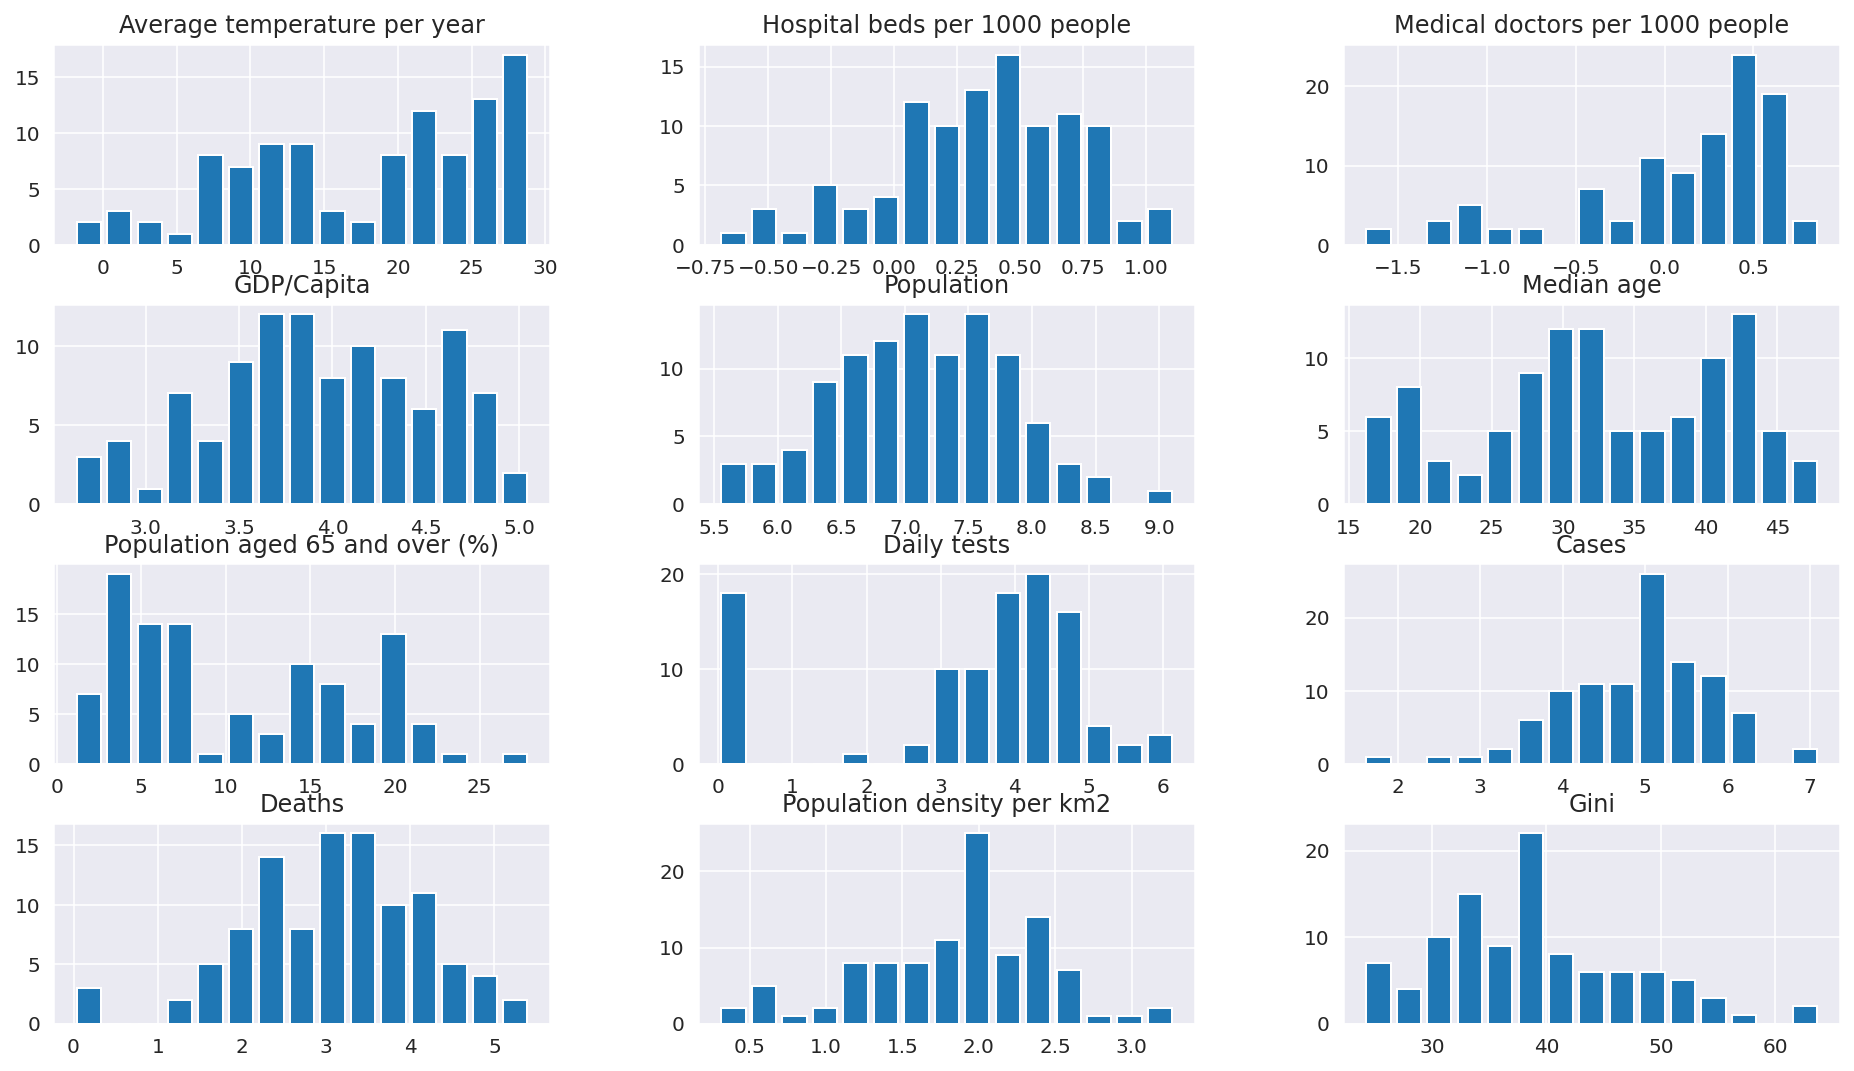

In [29]:
data.hist(bins=15, figsize=(16, 9), rwidth=0.8)
plt.show()

Корреляционная матрица

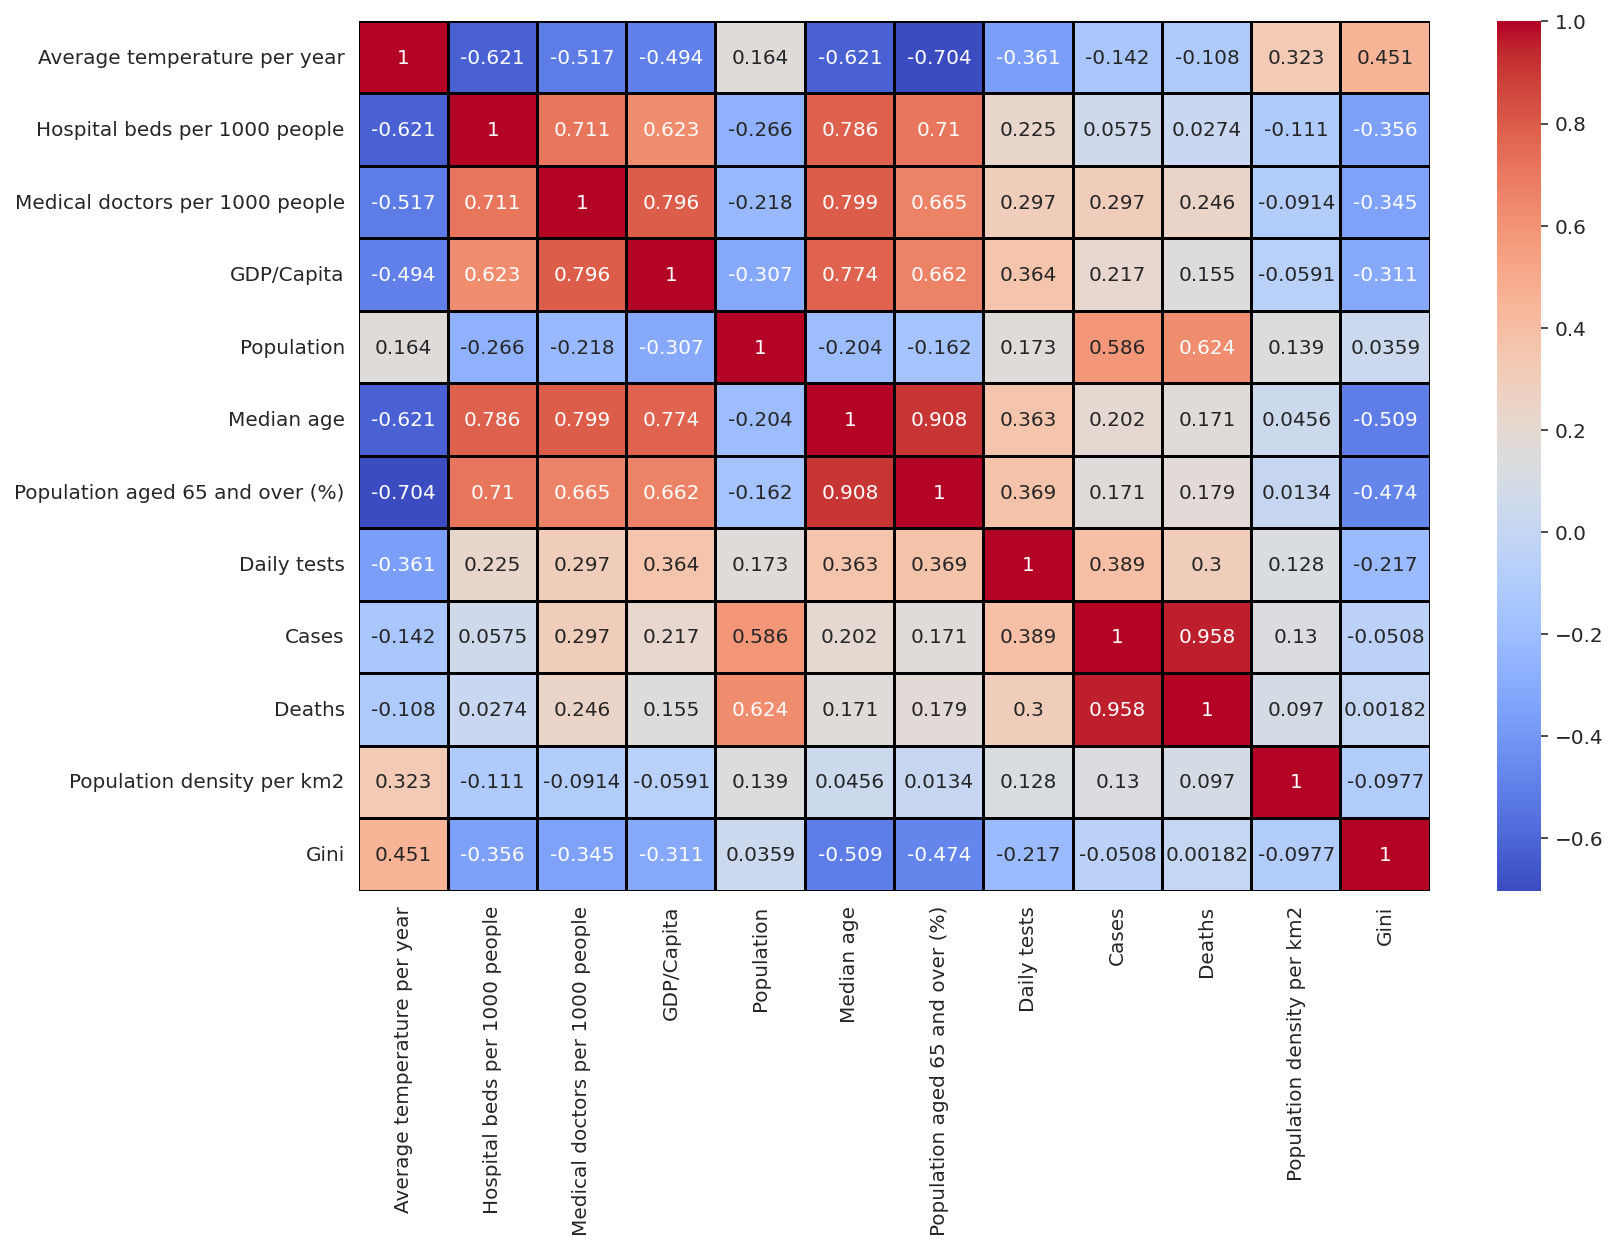

In [30]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.3g',
            linecolor='black', linewidths=1)
plt.show()

Графики рассеивания

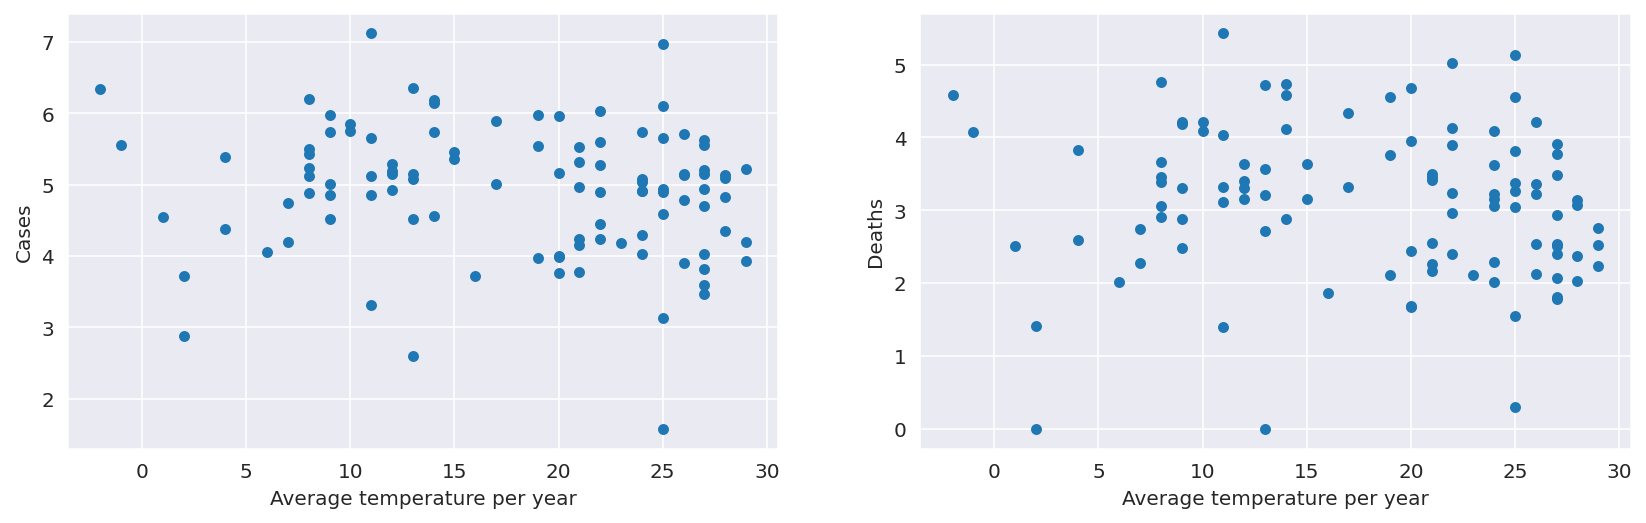

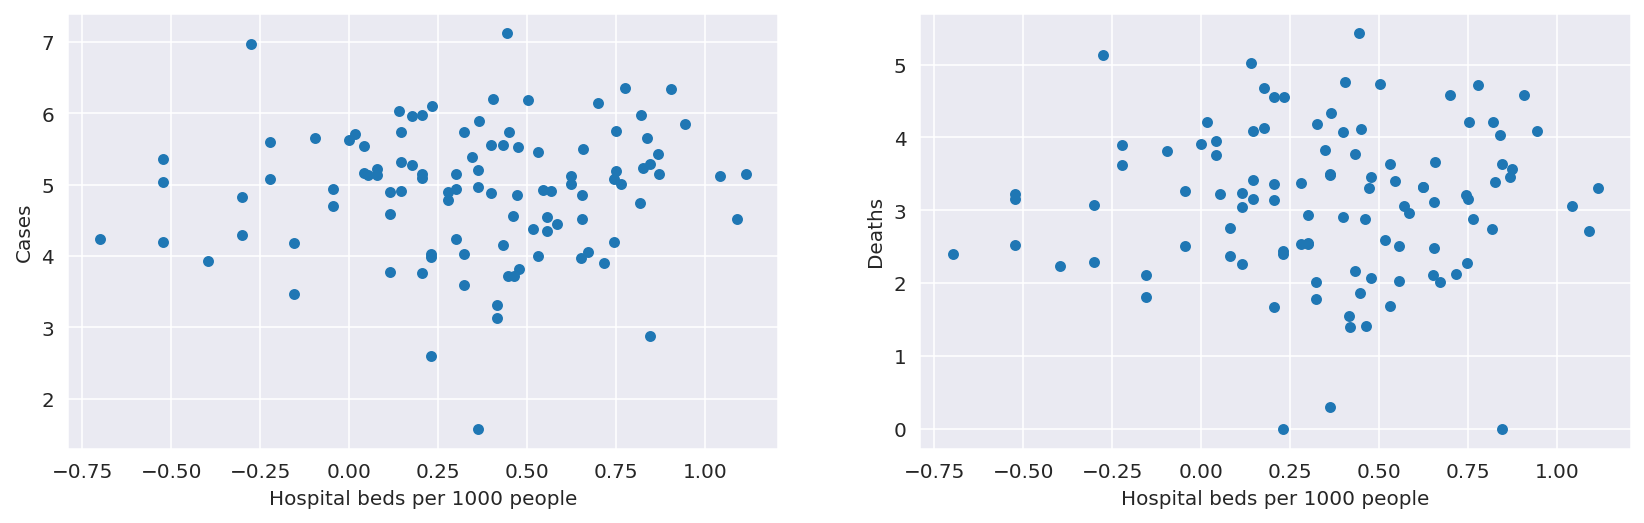

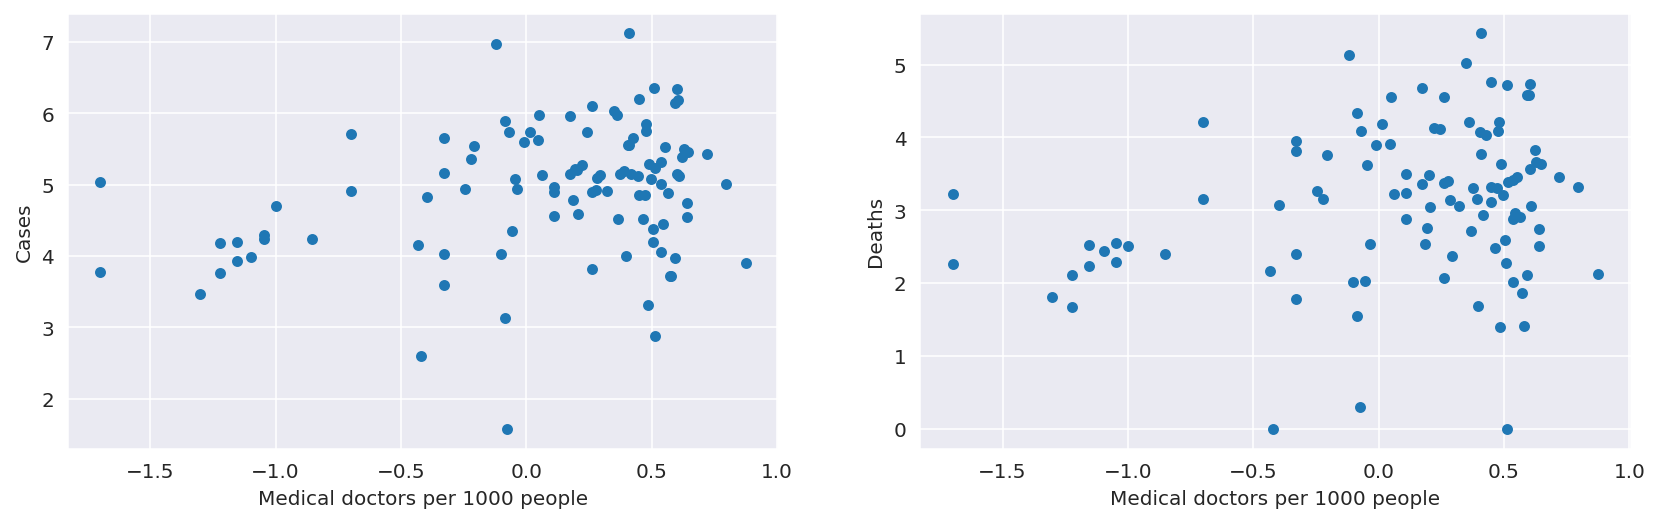

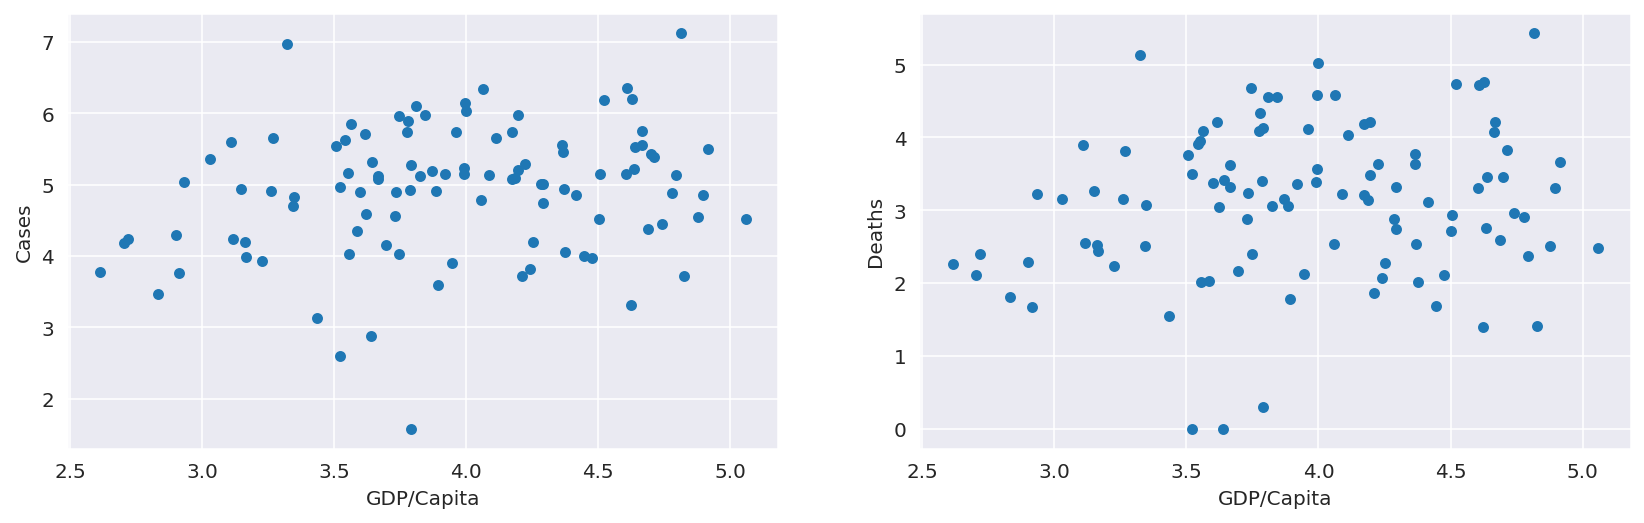

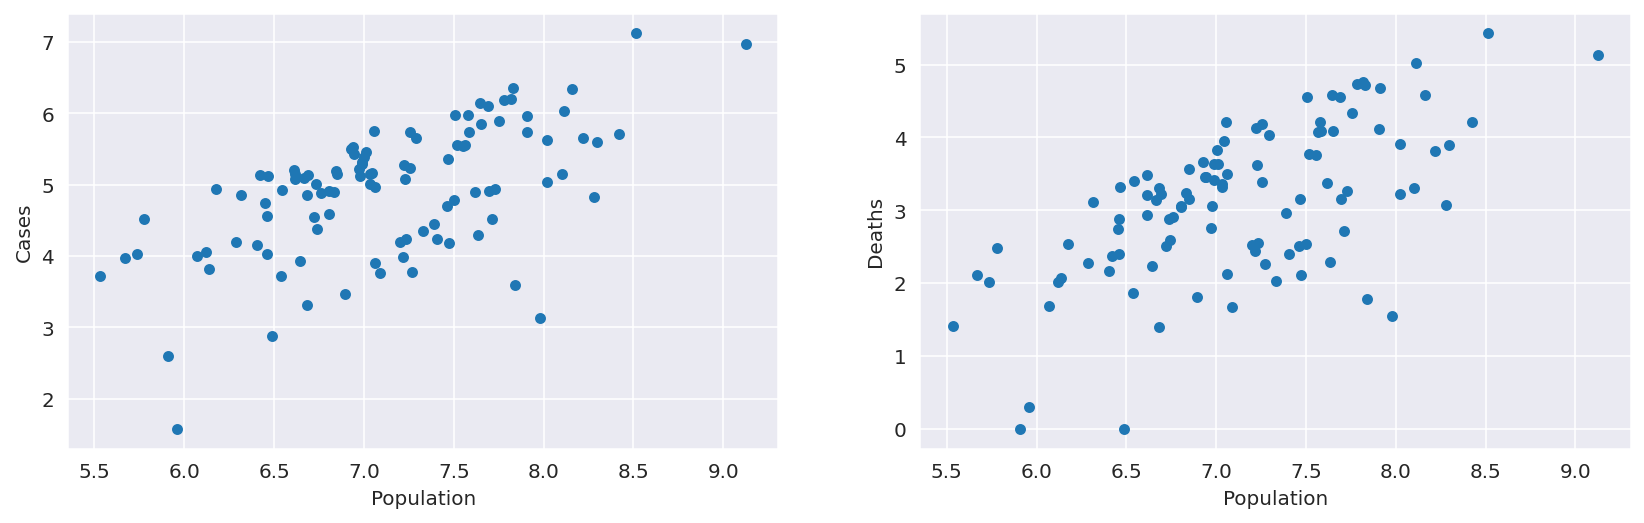

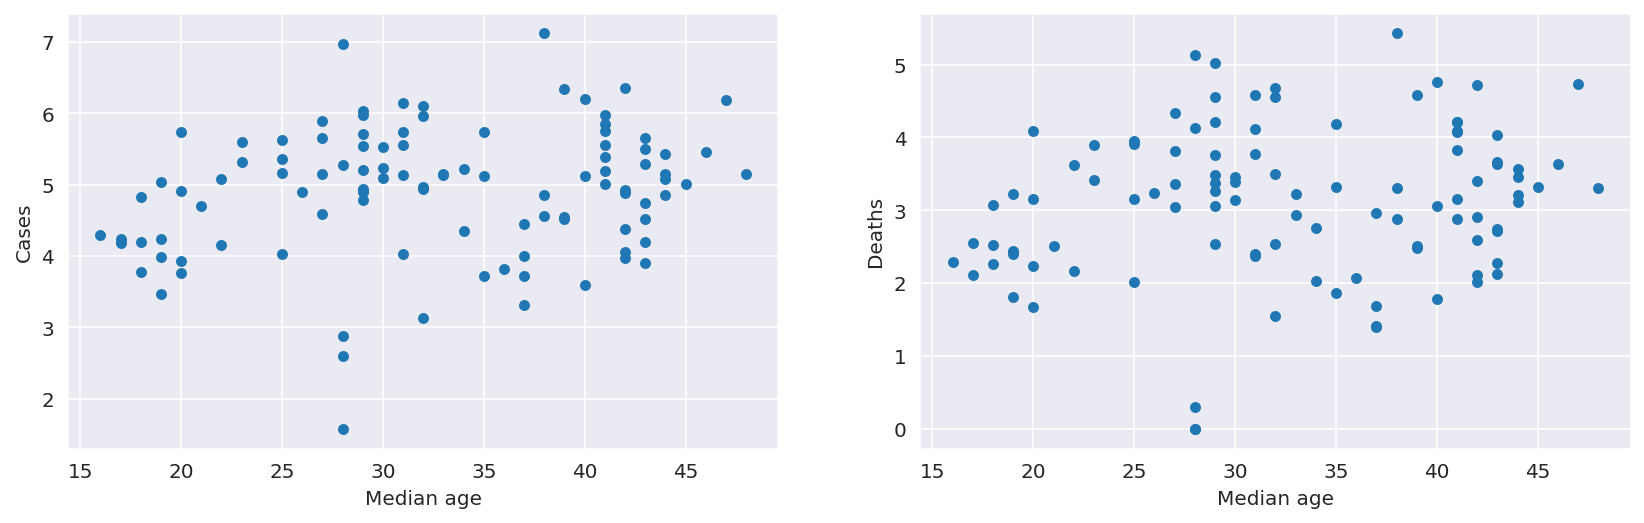

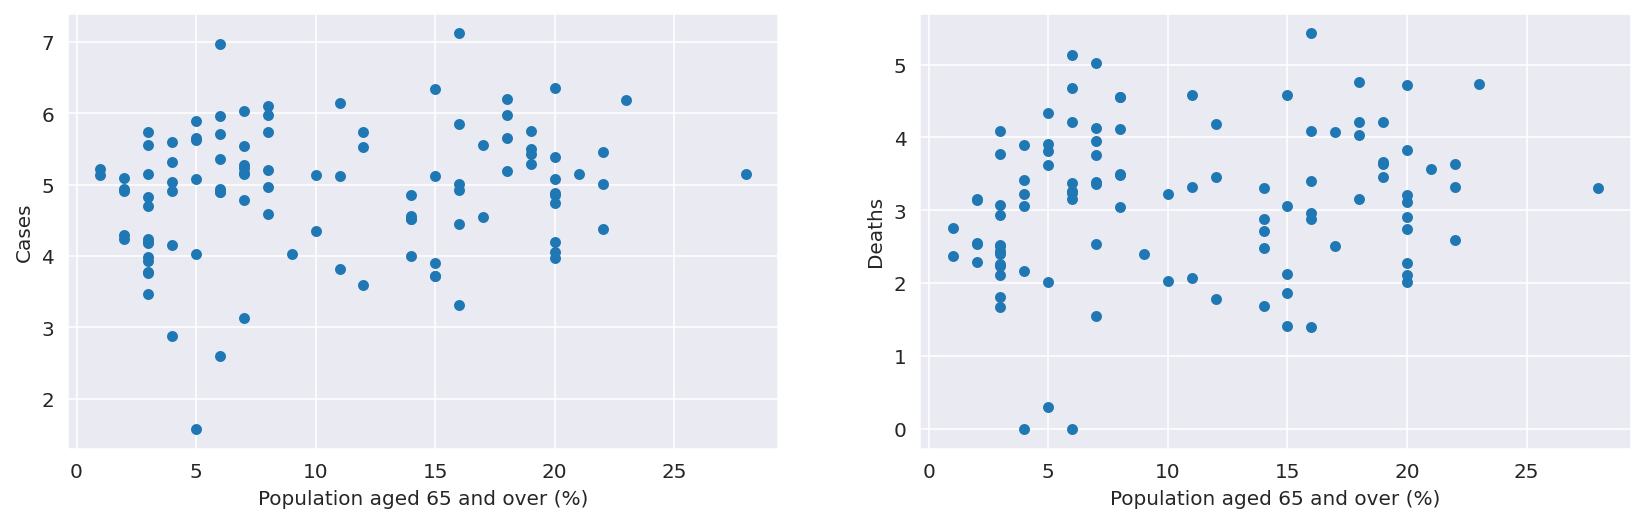

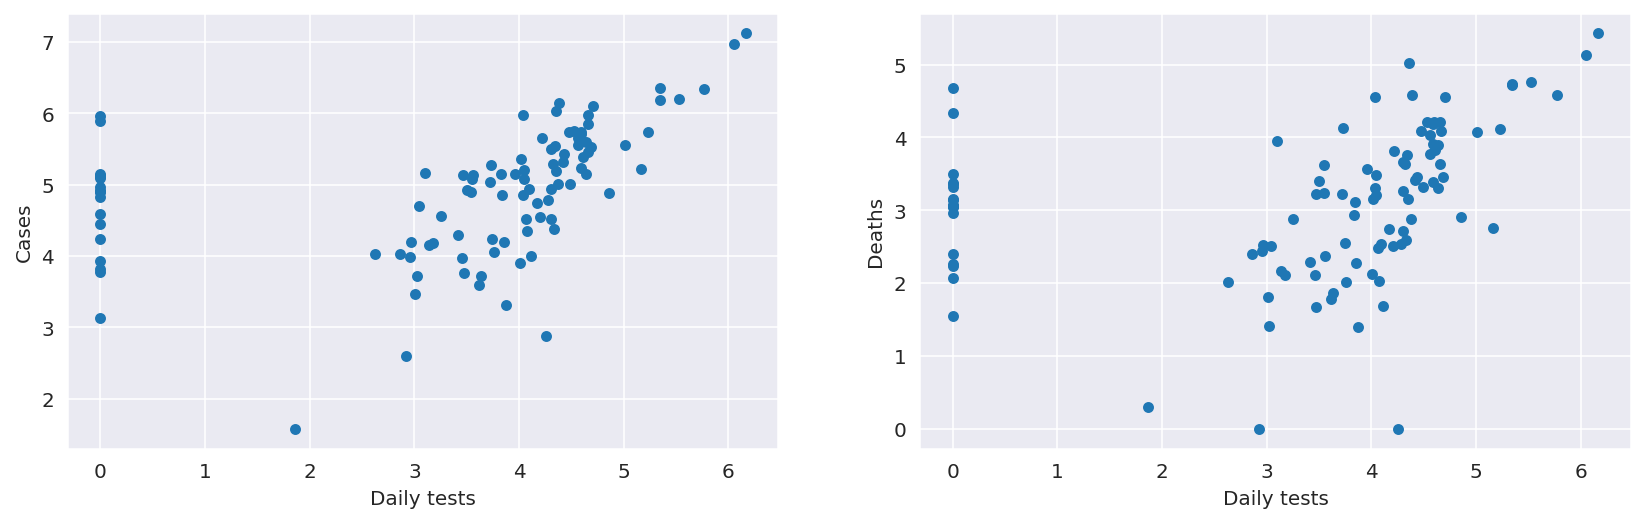

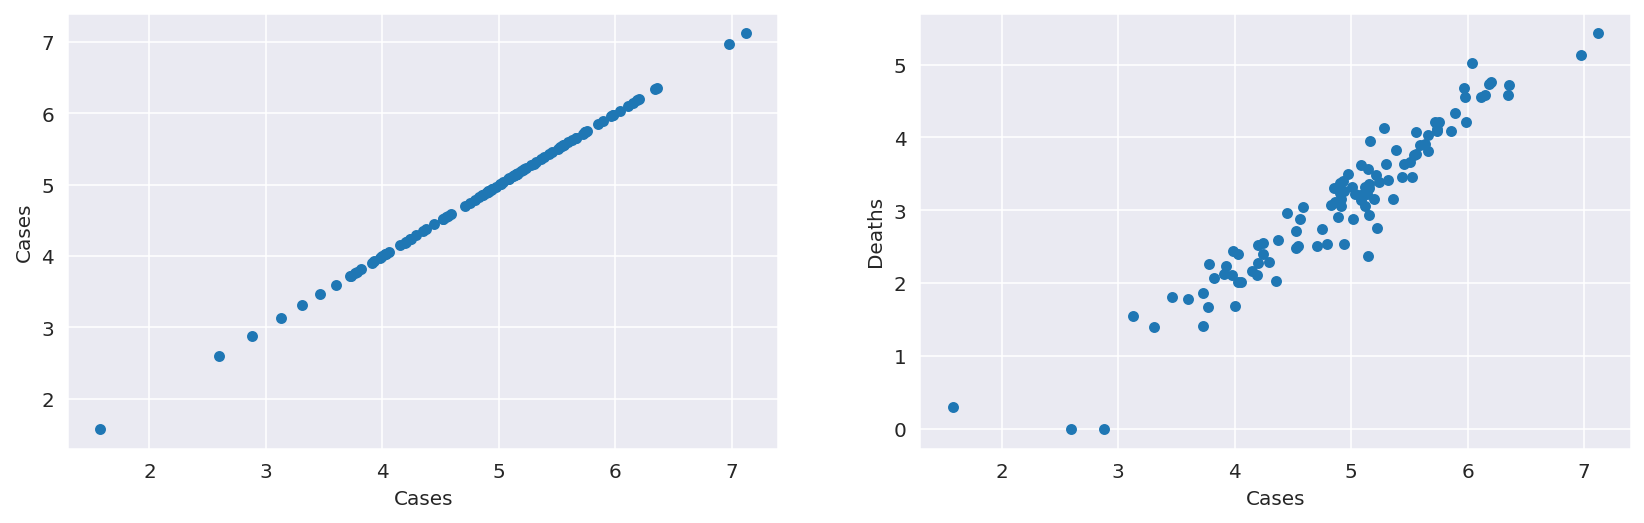

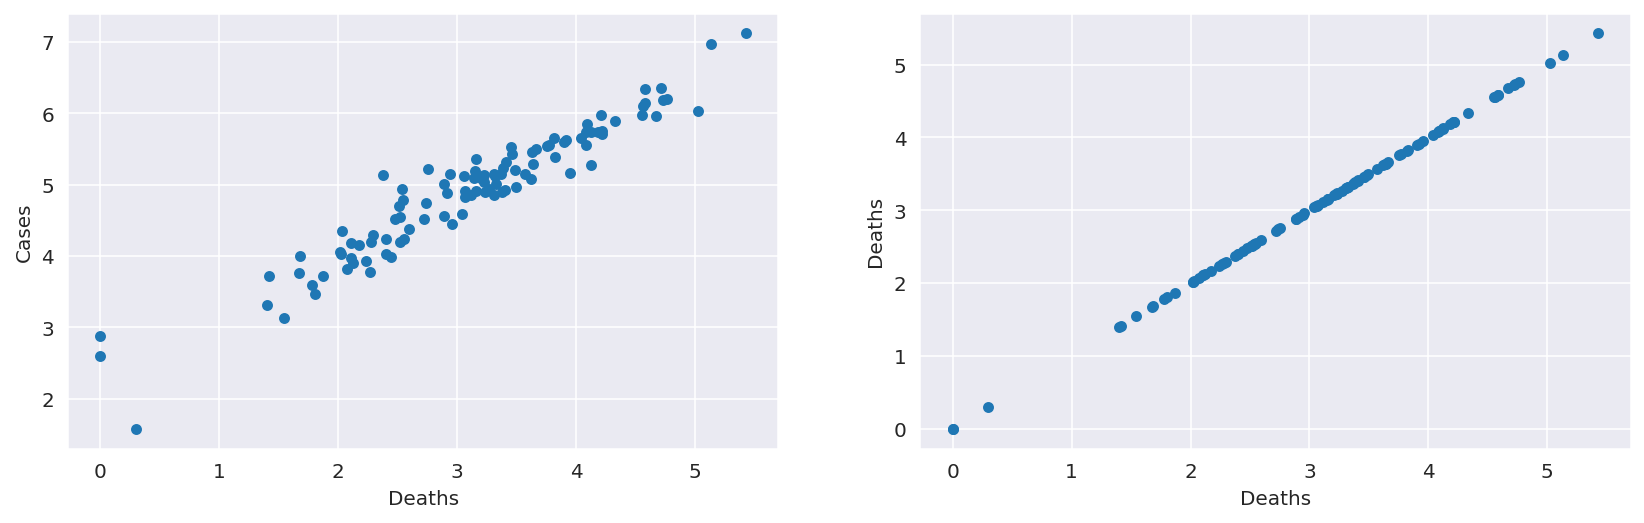

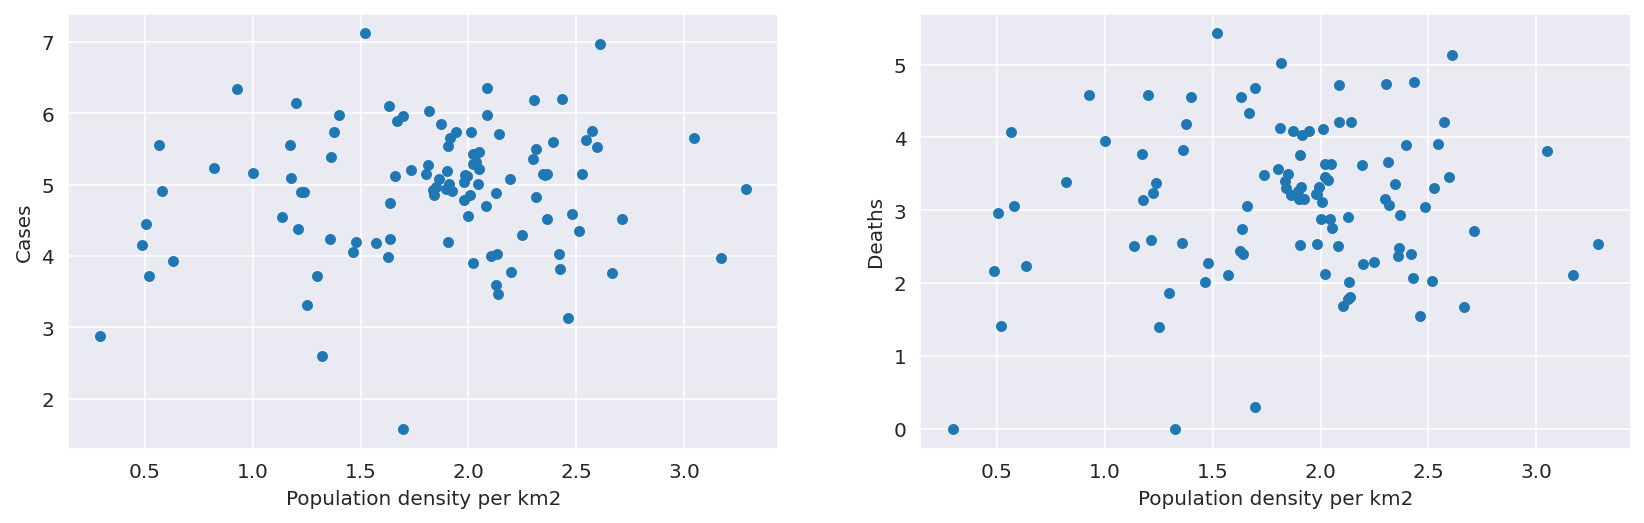

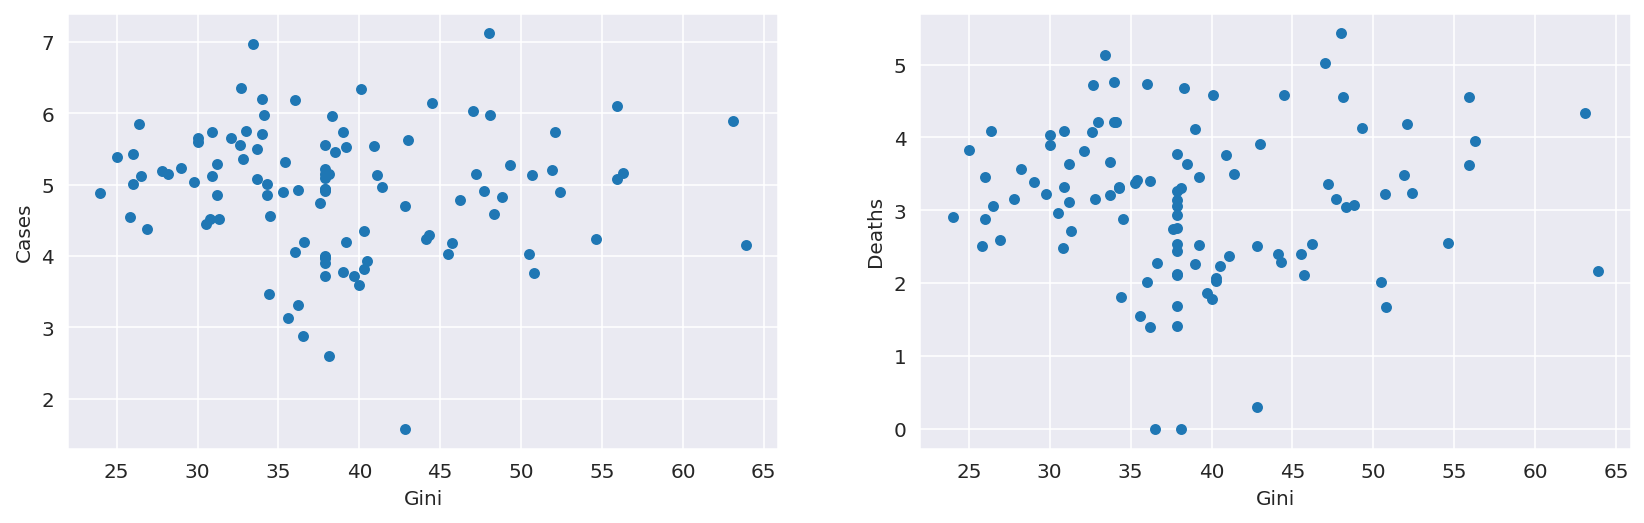

In [31]:
for column in data.columns:
    fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
    data.plot.scatter(x=column, y='Cases', ax=ax[0])
    data.plot.scatter(x=column, y='Deaths', ax=ax[1])

Подготовительные функции

In [32]:
def draw_plot(model, X):
    sorted_weights = sorted(zip(model.coef_.ravel(), X.columns), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    df = pd.DataFrame({'features': features, 'weights':weights})
    ax = df.plot.barh(x='features', y='weights', rot=0, )

In [33]:
def linear_model_check(X, y):
    linear = LinearRegression()
    linear.fit(X, y)
    print('LinearRegression:', 'r2 =', linear.score(X, y).round(3))
    print()
    print('Coefs:')
    coefs_data = pd.Series(linear.coef_.round(3), index=X.columns)
    print('Intercept:                       ', linear.intercept_.round(3))
    print(coefs_data)
    draw_plot(linear, X)

In [34]:
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(model, Y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * Y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=Y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')

In [35]:
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

In [36]:
def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')

Первая модель

Предсказывает смертность в стране на основе всех показателей

LinearRegression: r2 = 0.943

Coefs:
Intercept:                        -3.059
Average temperature per year       0.008
Hospital beds per 1000 people     -0.052
Medical doctors per 1000 people    0.007
GDP/Capita                        -0.053
Population                         0.138
Median age                        -0.011
Population aged 65 and over (%)    0.038
Daily tests                       -0.051
Cases                              1.079
Population density per km2        -0.080
Gini                               0.006
dtype: float64


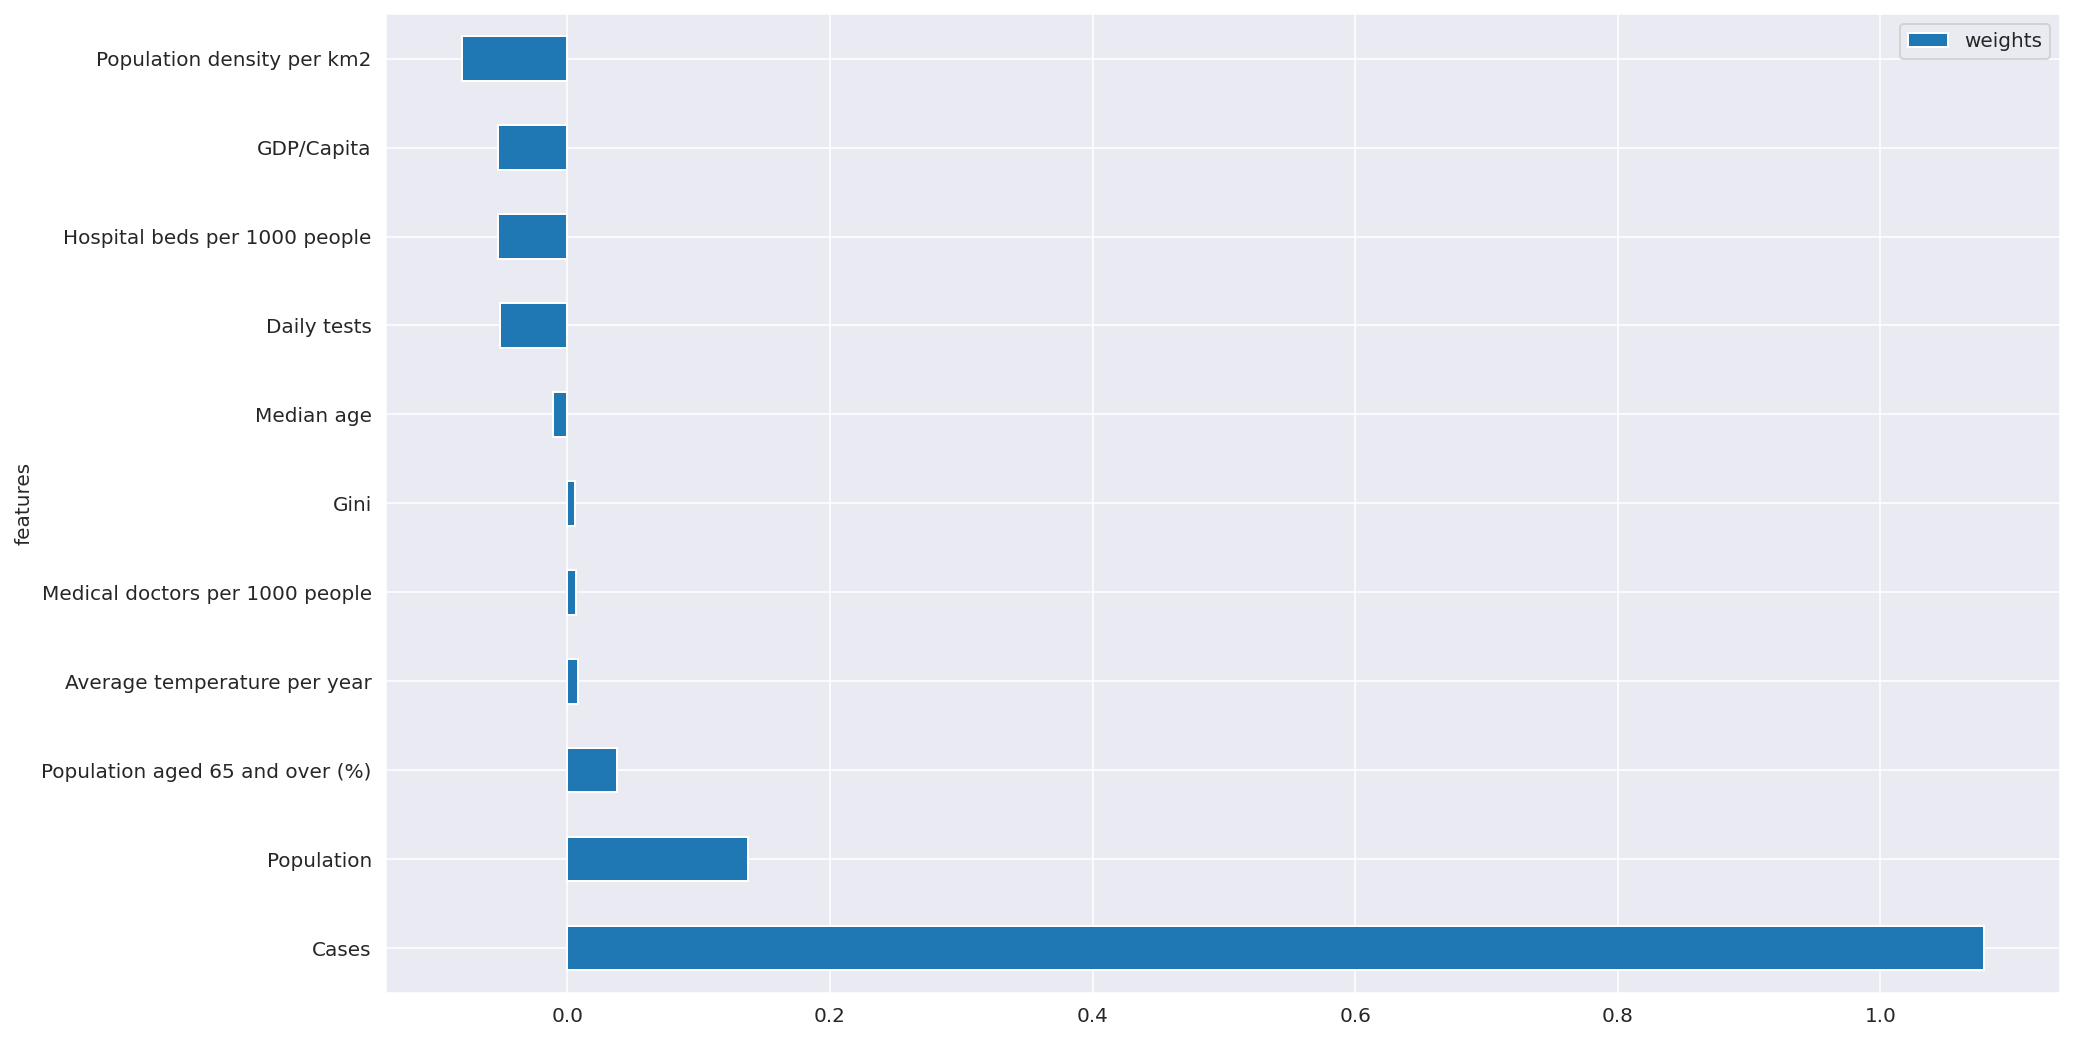

In [37]:
# Target: Deaths; Drops: No

X = fast_drop(data, ['Deaths'])
Y = data['Deaths']
linear_model_check(X, Y)

Проверка предпосылок теоремы Гаусса-Маркова

In [38]:
X_constant = sm.add_constant(X)
lin_reg = sm.OLS(Y, X_constant).fit()
lin_reg.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Deaths   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     138.9
Date:                Mon, 23 May 2022   Prob (F-statistic):           2.94e-52
Time:                        09:08:06   Log-Likelihood:                -2.1145
No. Observations:                 104   AIC:                             28.23
Df Residuals:                      92   BIC:                             59.96
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -3.0586      0.549     -5.576      0.000      -4.148      -1.969
Average temperature per year        0.0085      0.006      1.455      0.149      -0.003       0.020
Hospital beds per 1000 people      -0.0525      0.125     -0.419      0.676      -0.301       0.196
Medical doctors per 1000 people     0.0070      0.095      0.074      0.941      -0.181       0.195
GDP/Capita                         -0.0525      0.086     -0.614      0.541      -0.223       0.118
Population                          0.1377      0.058      2.371      0.020       0.022       0.253
Median age                         -0.0110      0.011     -1.005      0.317      -0.033       0.011
Population aged 65 and over (%)     0.0381      0.011      3.543      0.001       0.017       0.059
Daily tests                        -0.0514      0.018     -2.784      0.007      -0.088      -0.015
Cases                               1.0786      0.045     23.771      0.000       0.988       1.169
Population density per km2         -0.0802      0.054     -1.488      0.140      -0.187       0.027
Gini                                0.0063      0.004      1.607      0.111      -0.001       0.014
==============================================================================
Omnibus:                        6.644   Durbin-Watson:                   2.284
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                7.901
Skew:                           0.340   Prob(JB):                       0.0192
Kurtosis:                       4.166   Cond. No.                     1.20e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

1. Линейность модели

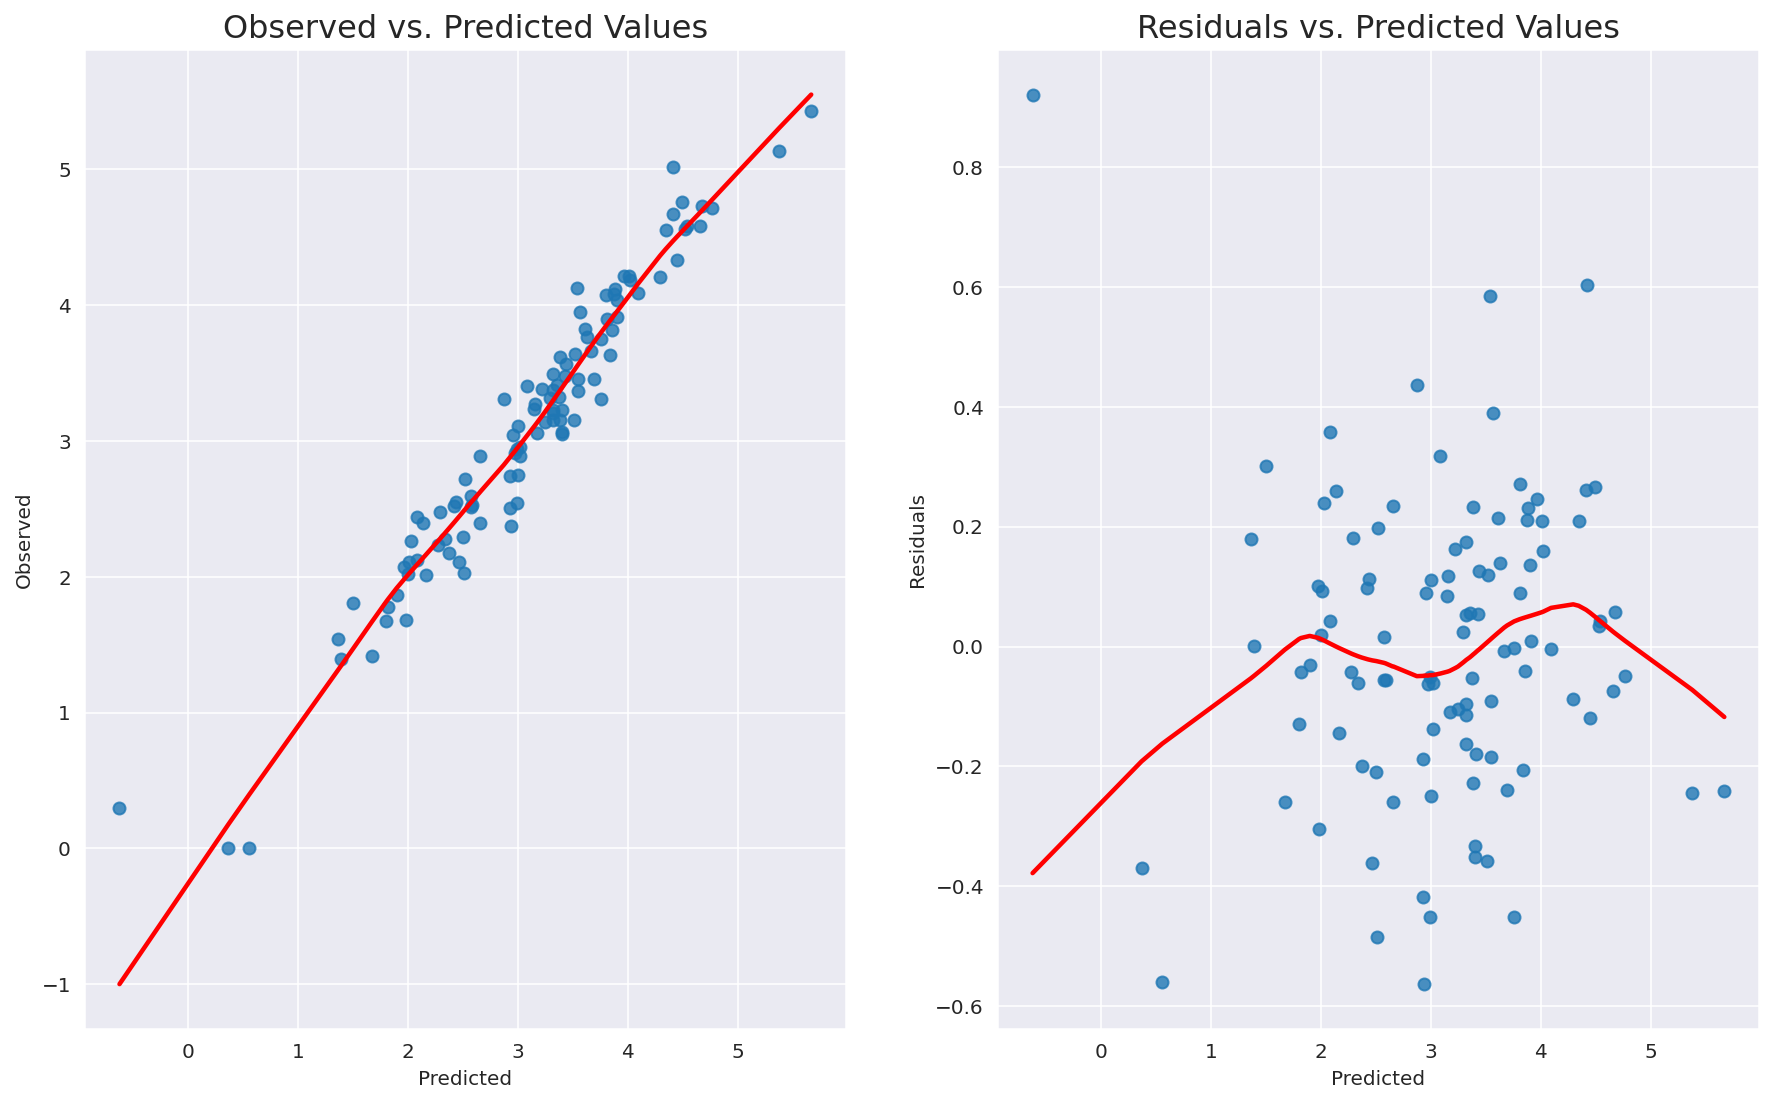

In [39]:
linearity_test(lin_reg, Y)    

Графики наблюдаемых и прогнозируемых значений или остатков и прогнозных значений. Желаемый результат - точки симметрично распределены вокруг прямой примерно с постоянной дисперсией (одинаковое расстояние до прямой).

На первом графике (наблюдаемые и предсказанные значения) линия почти прямая, на втором графике (остатки и предсказанные значения) линия не прямая.

В нашем случае линейность не выполняется.

2. Ожидание (среднее) остатков равно нулю

In [40]:
lin_reg.resid.mean()

1.2946908502551825e-14

Число очень маленькое, условие выполняется

3. Нет мультиколлинеарности

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).T

,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),Daily tests,Cases,Population density per km2,Gini
vif,3.344417,3.321984,4.447696,3.730206,2.363211,13.04779,7.932623,1.491067,2.52178,1.516381,1.603832


Если функции не связаны, то все значения будут равны 1.

В нашем случае мультиколлинеарность есть.

4. Гомоскедастичность (равная дисперсия) остатков


 Breusch-Pagan test ----
                                   value
Lagrange multiplier statistic  21.403975
p-value                         0.029419
f-value                         2.167357
f p-value                       0.022833

 Goldfeld-Quandt test ----
                value
F statistic  0.856828
p-value      0.686284

 Residuals plots ----


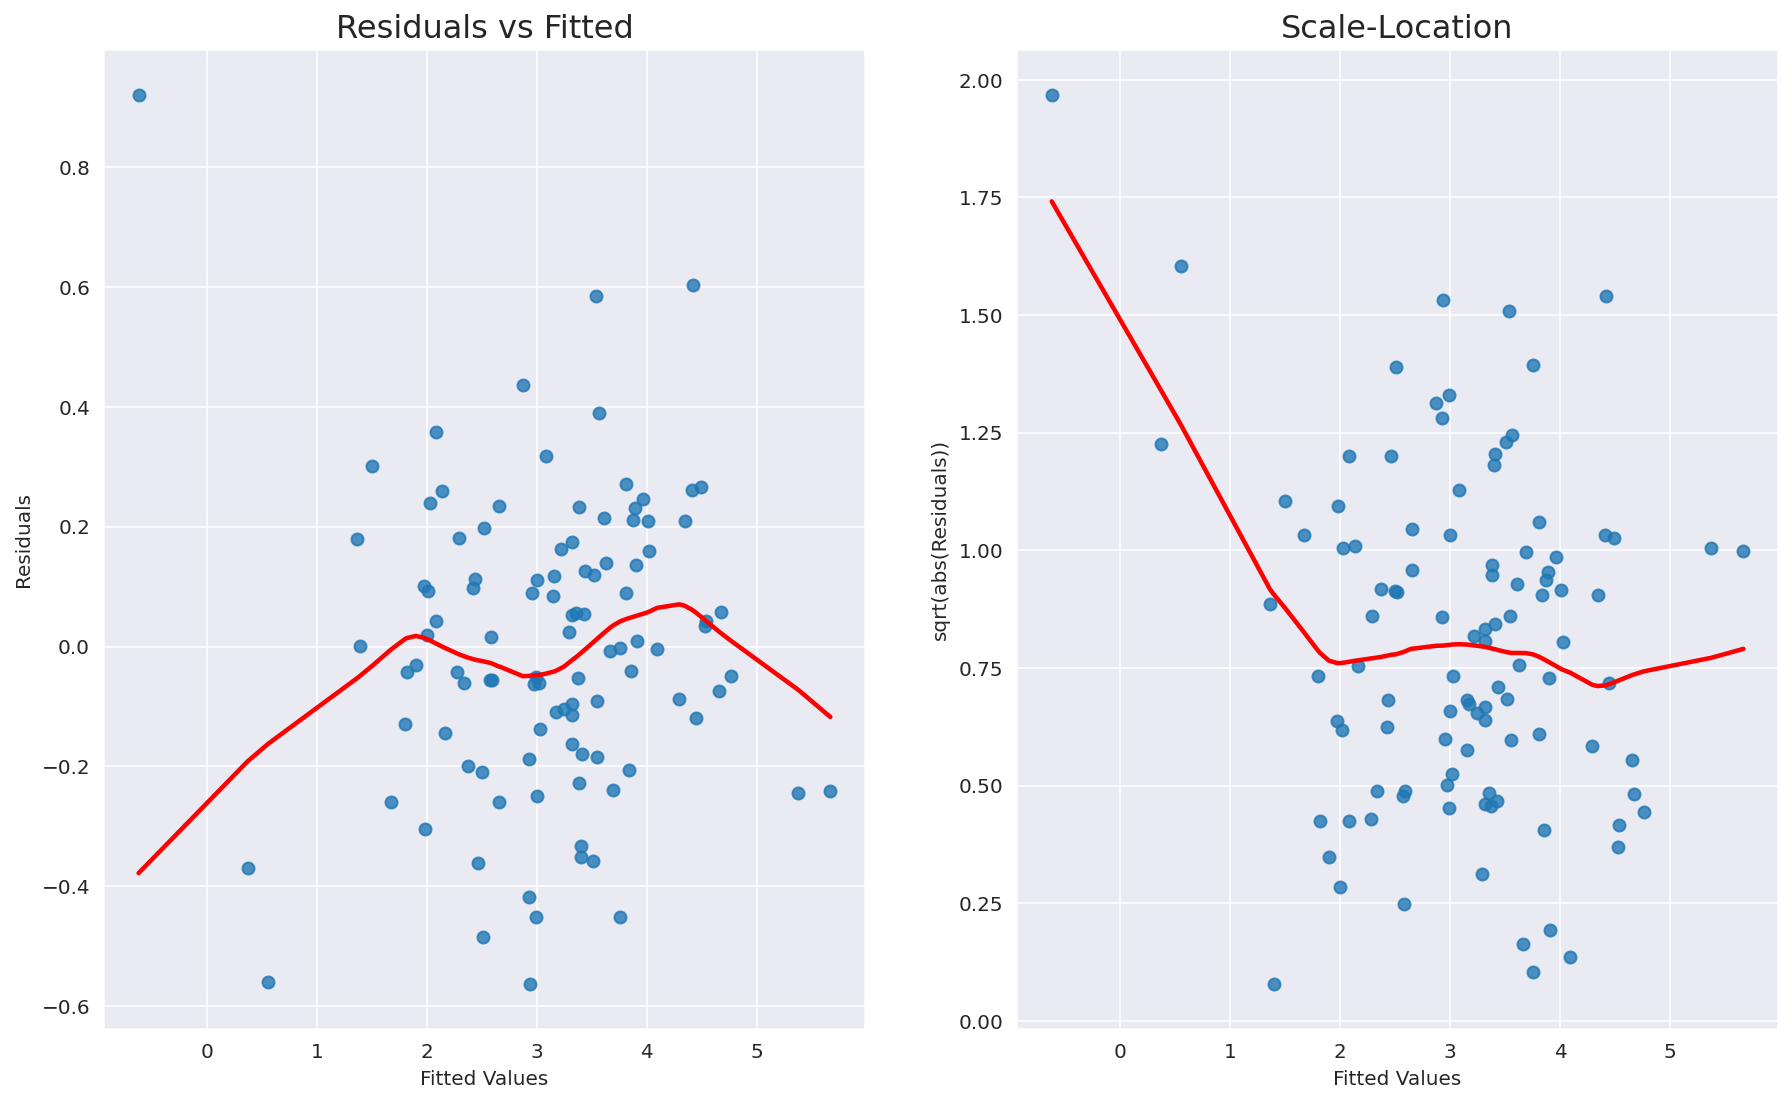

In [42]:
homoscedasticity_test(lin_reg)

Графики зависимости остатков от прогнозируемых значений. Расположение точек должно быть случайным, не должно быть шаблона увеличения/уменьшения значений остатков (красная линия должна быть плоской).

В нашем случае линии не прямые, условие не выполняется.

Тесты Бройша-Пагана и Гольдфельда-Квандта. В обоих случаях нулевая гипотеза предполагает гомоскедастичность, а значение p-value ниже уровня, например, 0,05 указывает на то, что мы должны отвергнуть ноль в пользу гетероскедастичности.

В нашем случае тест Бройша-Пагана показал гетероскедастичность, а тест Гольдфельда-Квандта - гомоскедастичность. Получился пограничный случай. В общем, условие скорее не выполняется.

5. Нет автокорреляции остатков

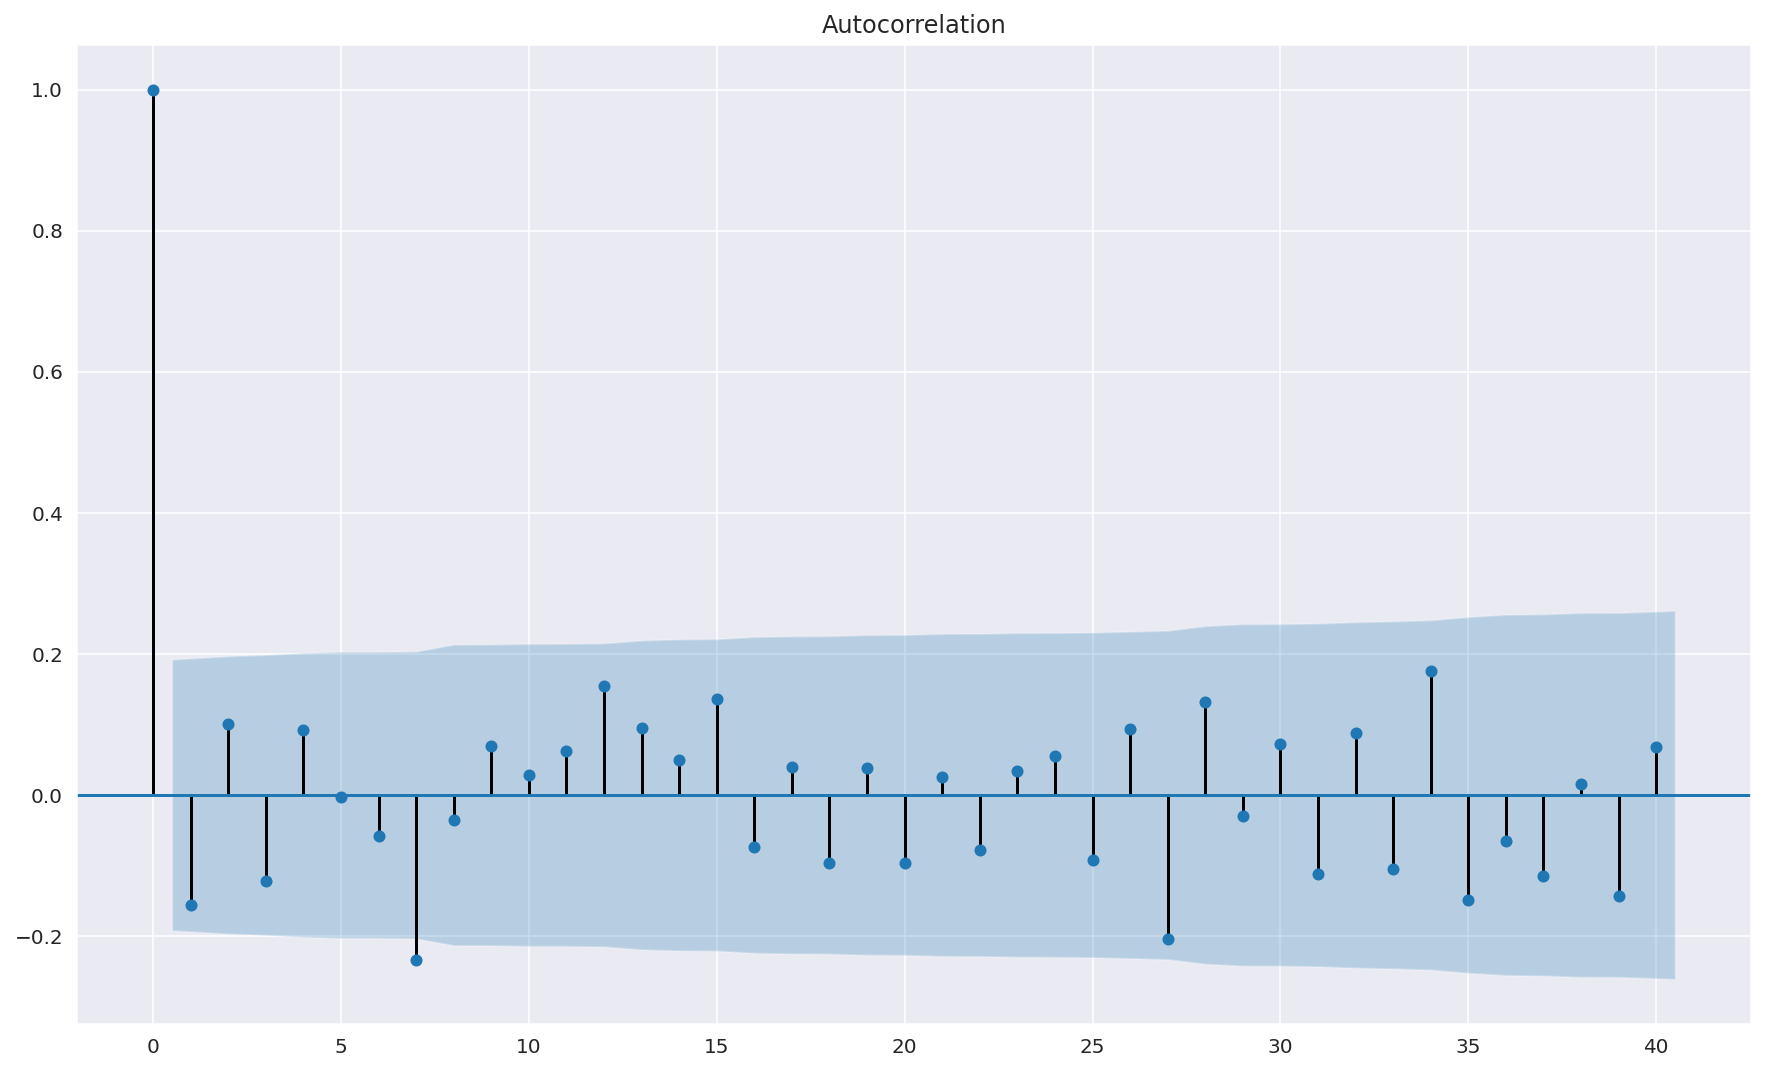

In [43]:
import statsmodels.tsa.api as smt

acf = smt.graphics.plot_acf(lin_reg.resid, lags=40 , alpha=0.05)
acf.show()

График ACF. Первое значение выходит за рамки доверительного интервала, остальные (кроме одного немного) в него входят, значит автокорреляции на уровне значимости 0,05 нет.

In [44]:
import statsmodels
statsmodels.stats.stattools.durbin_watson(lin_reg.resid, axis=0)

2.284201952103538

Тест Дурбина-Ватсона. Значение 2 - автокорреляции нет.

В нашем случае значение больше 2, что значит в образце отрицательная автокорреляция, если нестрого - ее нет.

Нормальность случайной ошибки для первой модели

Jarque-Bera test ---- statistic: 7.9005, p-value: 0.01924946125338778
Shapiro-Wilk test ---- statistic: 0.9799, p-value: 0.1148
Kolmogorov-Smirnov test ---- statistic: 0.3173, p-value: 0.0000
Anderson-Darling test ---- statistic: 0.3421, 5% critical value: 0.7600


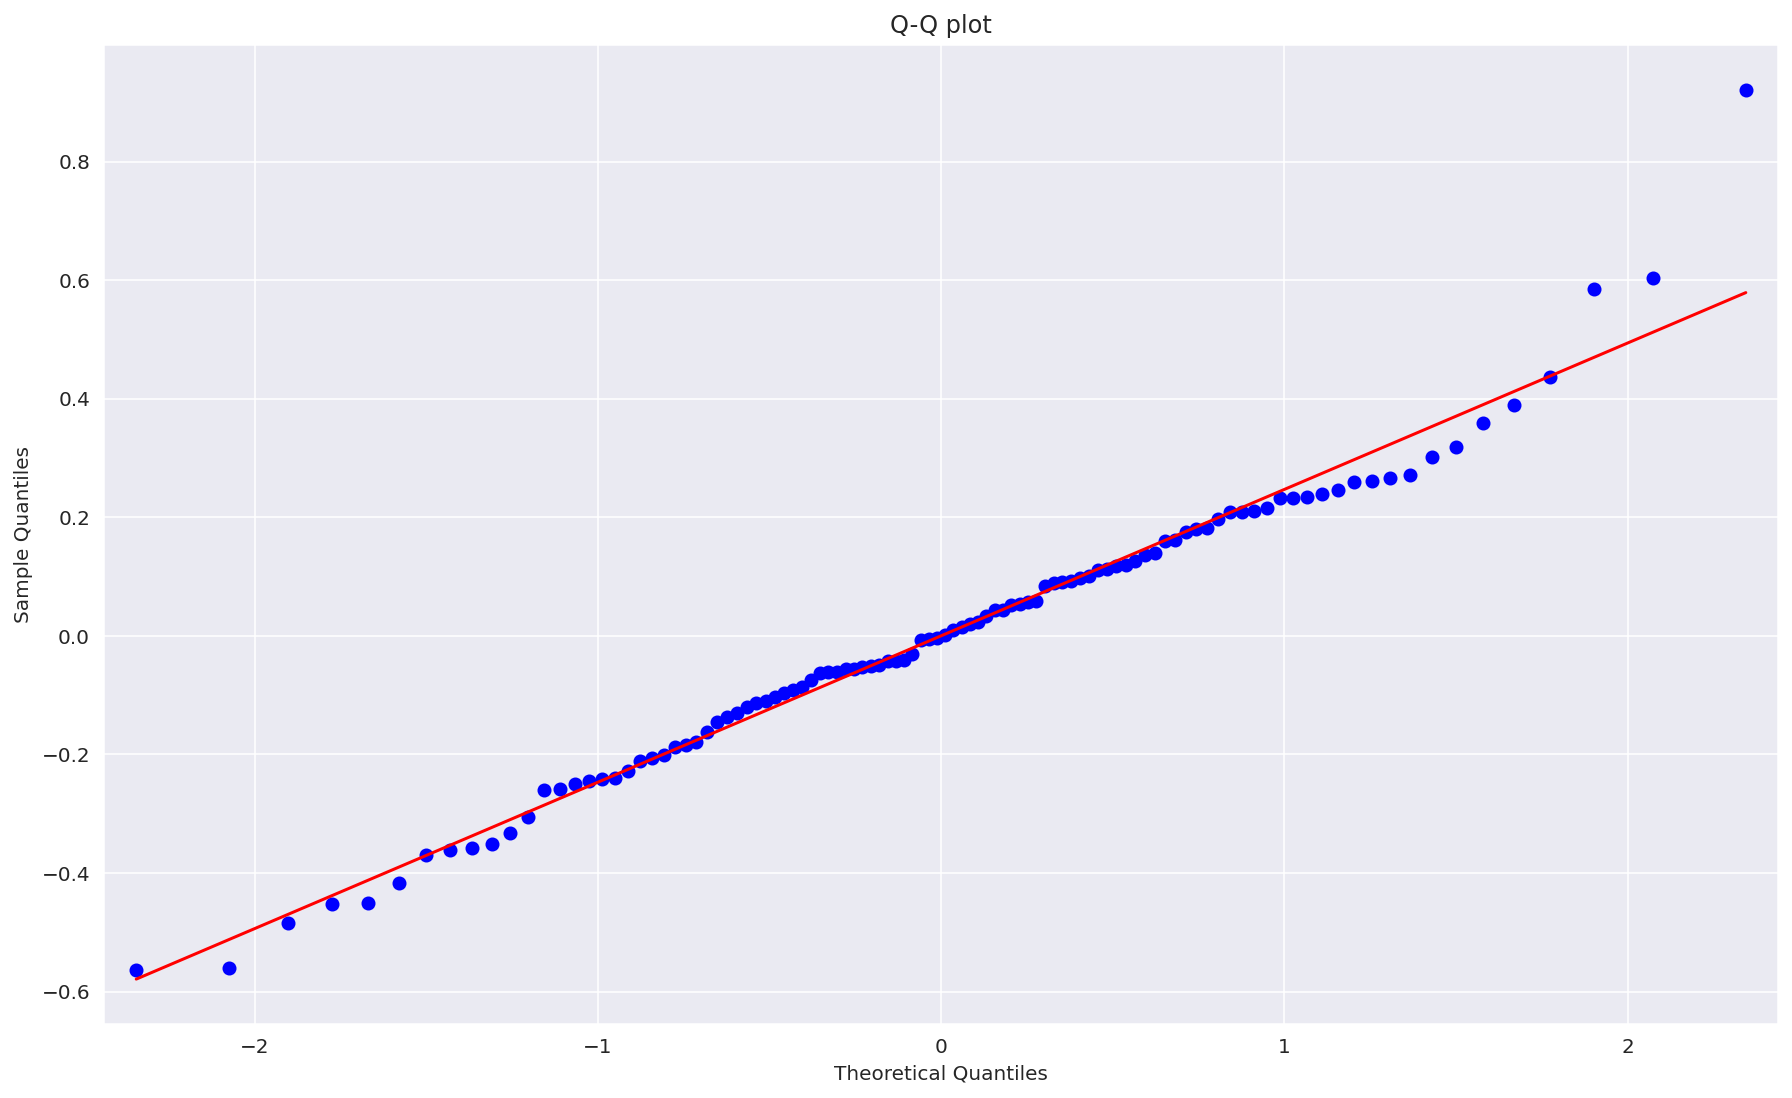

In [45]:
normality_of_residuals_test(lin_reg)

Гипотеза о нормальности распределния отвергается во всех тестах.

Вторая модель

Предсказывает смертность в стране, не учитывая показатели пандемии

LinearRegression: r2 = 0.594

Coefs:
Intercept:                        -6.295
Average temperature per year      -0.017
Hospital beds per 1000 people     -0.590
Medical doctors per 1000 people    0.723
GDP/Capita                         0.245
Population                         1.081
Median age                        -0.005
Population aged 65 and over (%)    0.018
Population density per km2         0.144
Gini                               0.023
dtype: float64


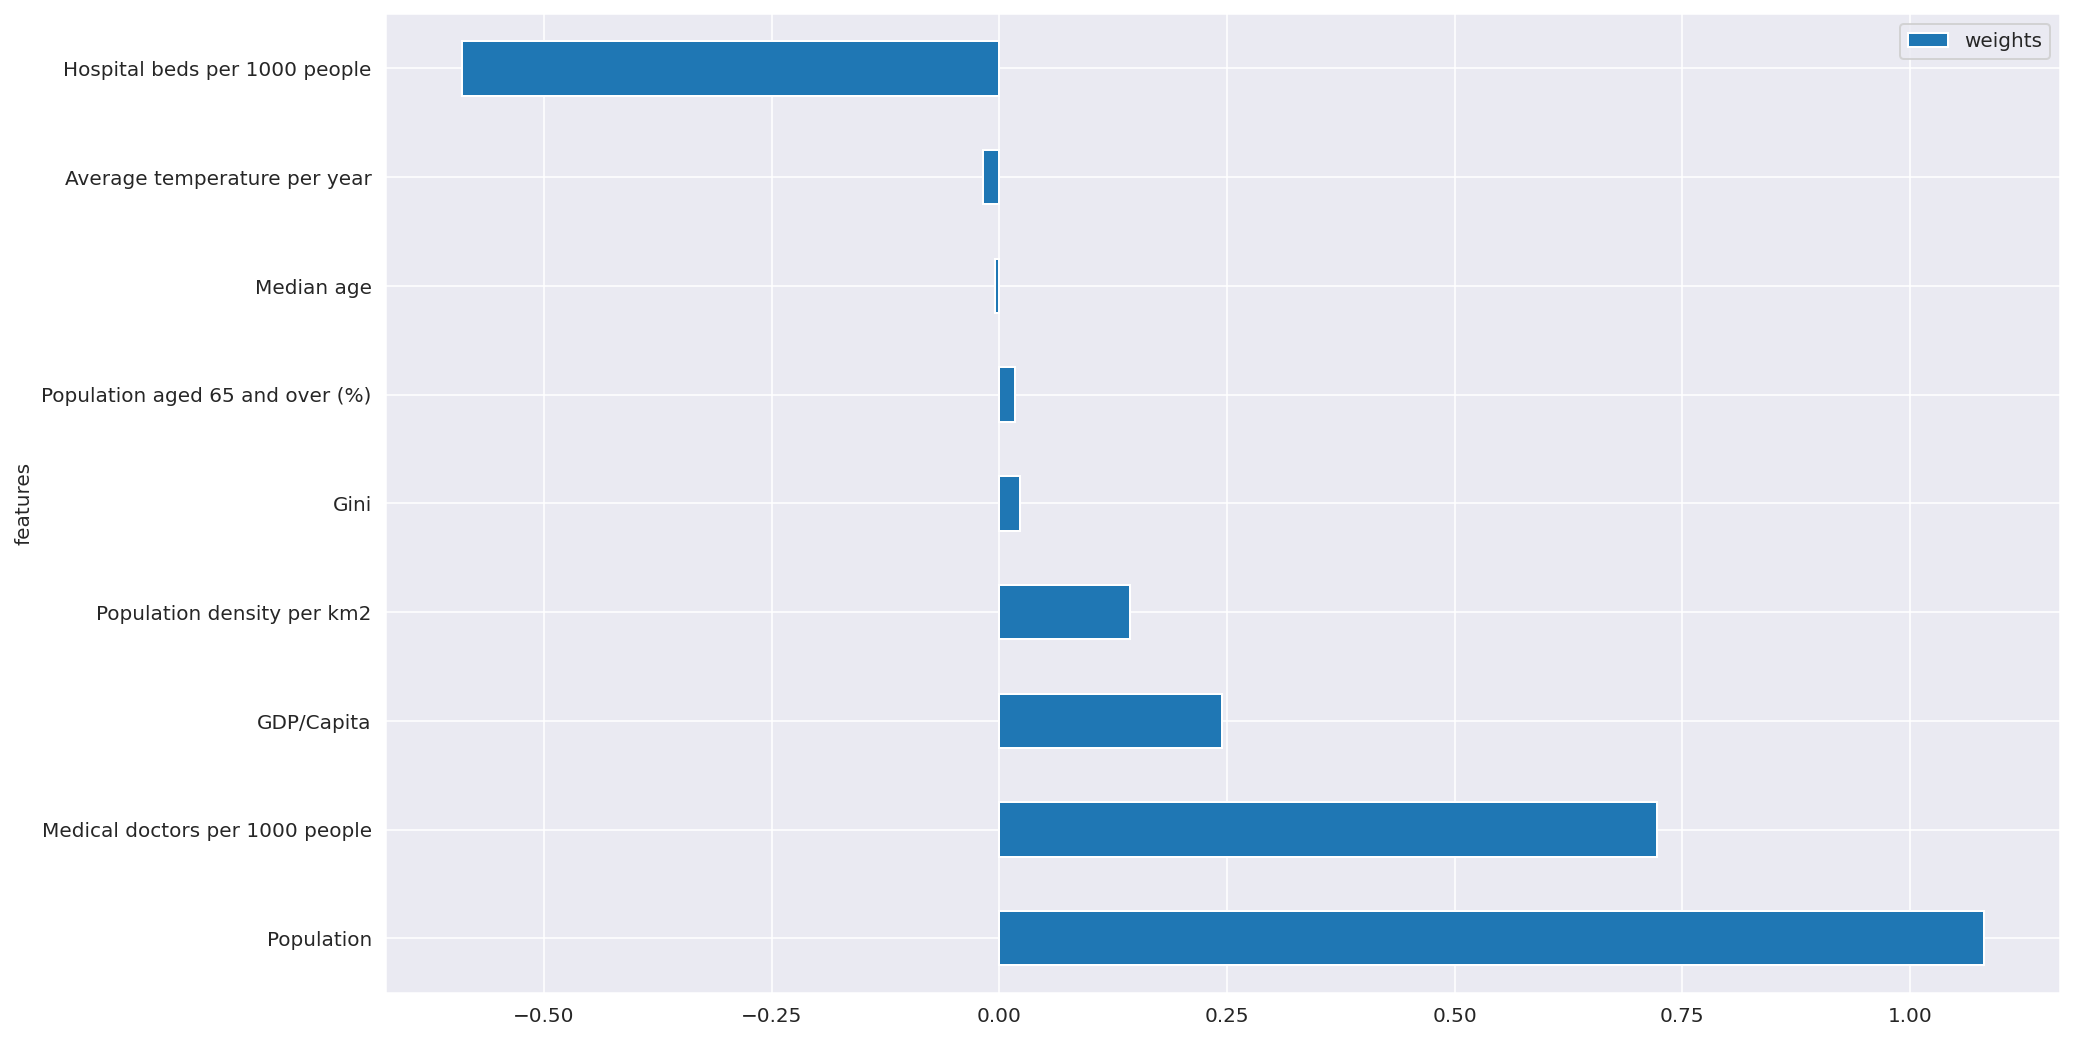

In [46]:
# Target: Deaths; Drops: Daily tests, Cases

X_2 = fast_drop(data, ['Deaths', 'Daily tests', 'Cases'])
Y_2 = data['Deaths']
linear_model_check(X_2, Y_2)

Проверка предпосылок теоремы Гаусса-Маркова и нормальности для второй модели модели

In [47]:
X_constant_2 = sm.add_constant(X_2)
lin_reg_2 = sm.OLS(Y_2, X_constant_2).fit()
lin_reg_2.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Deaths   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     15.29
Date:                Mon, 23 May 2022   Prob (F-statistic):           4.81e-15
Time:                        09:08:38   Log-Likelihood:                -104.36
No. Observations:                 104   AIC:                             228.7
Df Residuals:                      94   BIC:                             255.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -6.2946      1.376     -4.574      0.000      -9.027      -3.562
Average temperature per year       -0.0175      0.015     -1.201      0.233      -0.046       0.011
Hospital beds per 1000 people      -0.5901      0.324     -1.822      0.072      -1.233       0.053
Medical doctors per 1000 people     0.7225      0.237      3.045      0.003       0.251       1.194
GDP/Capita                          0.2448      0.218      1.121      0.265      -0.189       0.678
Population                          1.0810      0.108     10.054      0.000       0.867       1.294
Median age                         -0.0048      0.029     -0.165      0.870      -0.062       0.053
Population aged 65 and over (%)     0.0176      0.028      0.620      0.537      -0.039       0.074
Population density per km2          0.1440      0.137      1.051      0.296      -0.128       0.416
Gini                                0.0231      0.010      2.261      0.026       0.003       0.043
==============================================================================
Omnibus:                       23.736   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.255
Skew:                          -1.185   Prob(JB):                     1.63e-07
Kurtosis:                       4.262   Cond. No.                     1.14e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

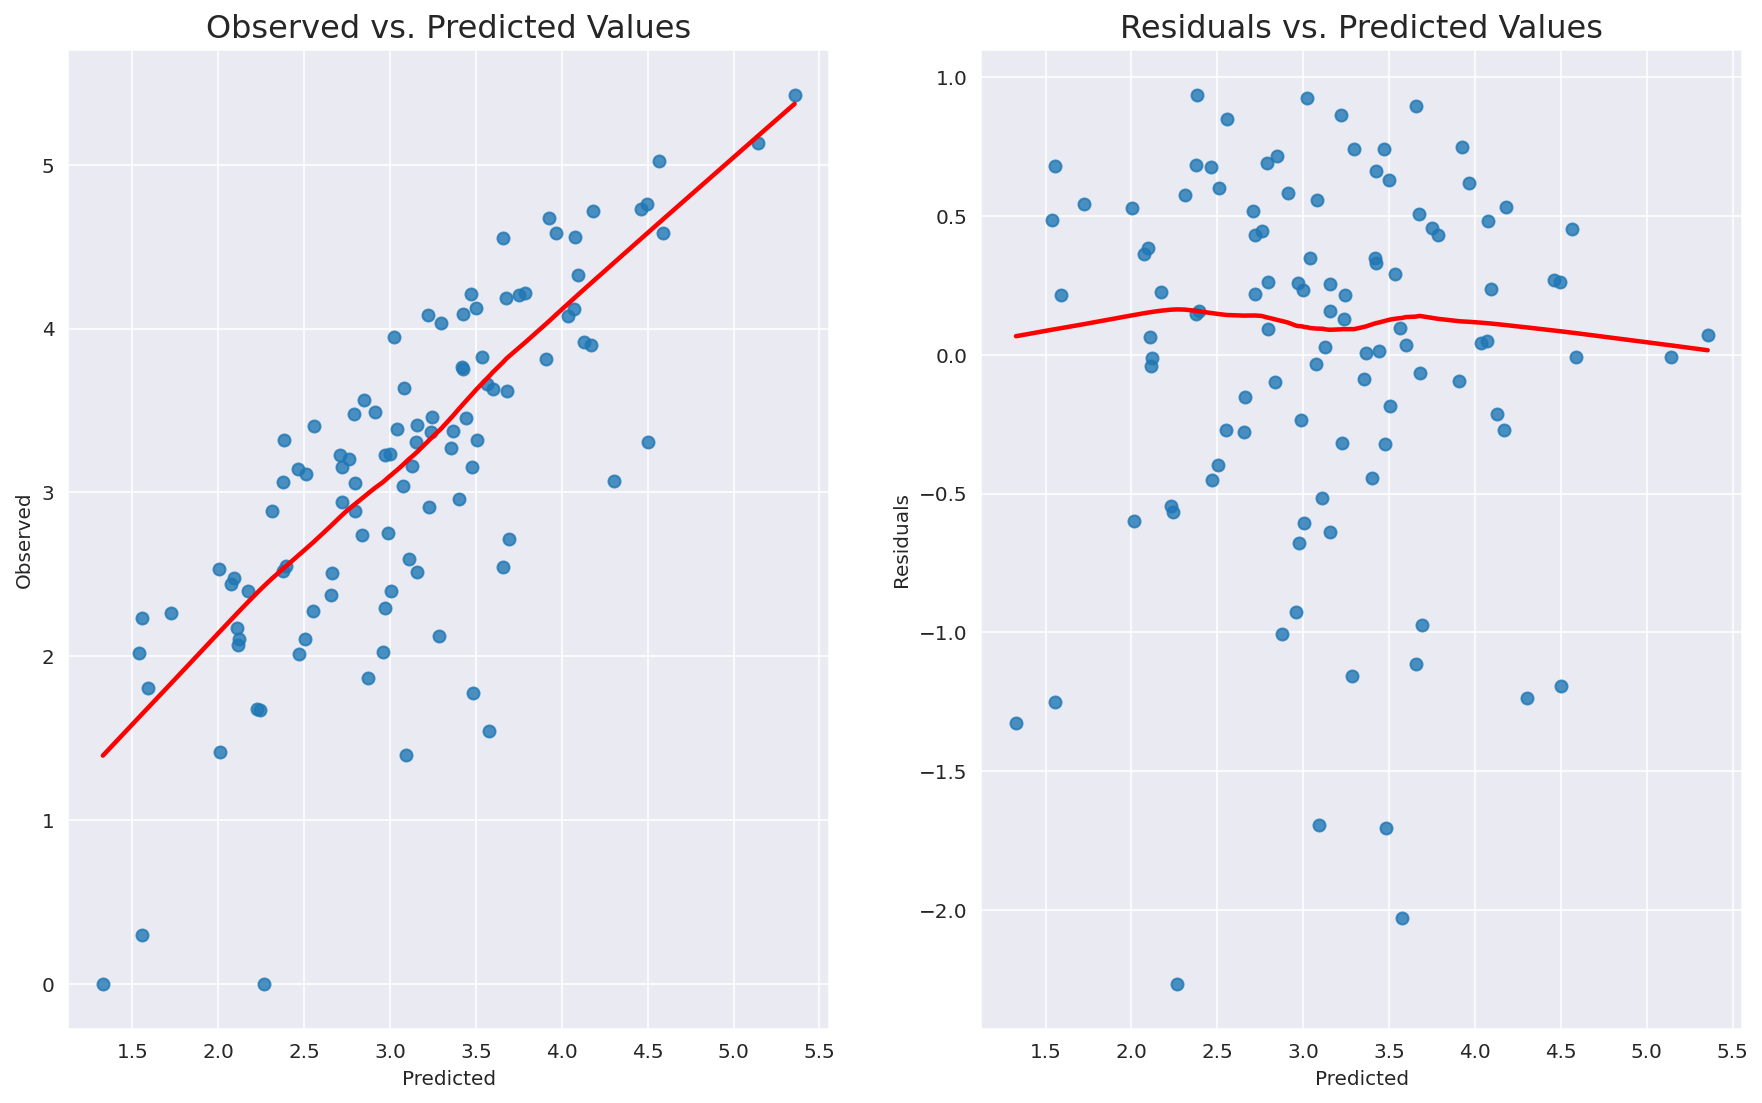

In [48]:
linearity_test(lin_reg_2, Y_2)

Линии почти прямые, можно сказать, что линейность выполняется, пограничный случай.

In [49]:
lin_reg_2.resid.mean()

8.986401366629392e-15

Значение около нуля, условие про ожидание остатков выполняется.

In [50]:
vif_2 = [variance_inflation_factor(X_constant_2.values, i) for i in range(X_constant_2.shape[1])]
pd.DataFrame({'vif': vif_2[1:]}, index=X_2.columns).T

,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),Population density per km2,Gini
vif,2.987428,3.183114,3.994534,3.468435,1.158708,13.030038,7.880191,1.398857,1.548748


Мультиколлинеарность есть.


 Breusch-Pagan test ----
                                   value
Lagrange multiplier statistic  10.829389
p-value                         0.287585
f-value                         1.213977
f p-value                       0.295837

 Goldfeld-Quandt test ----
                value
F statistic  1.920033
p-value      0.018616

 Residuals plots ----


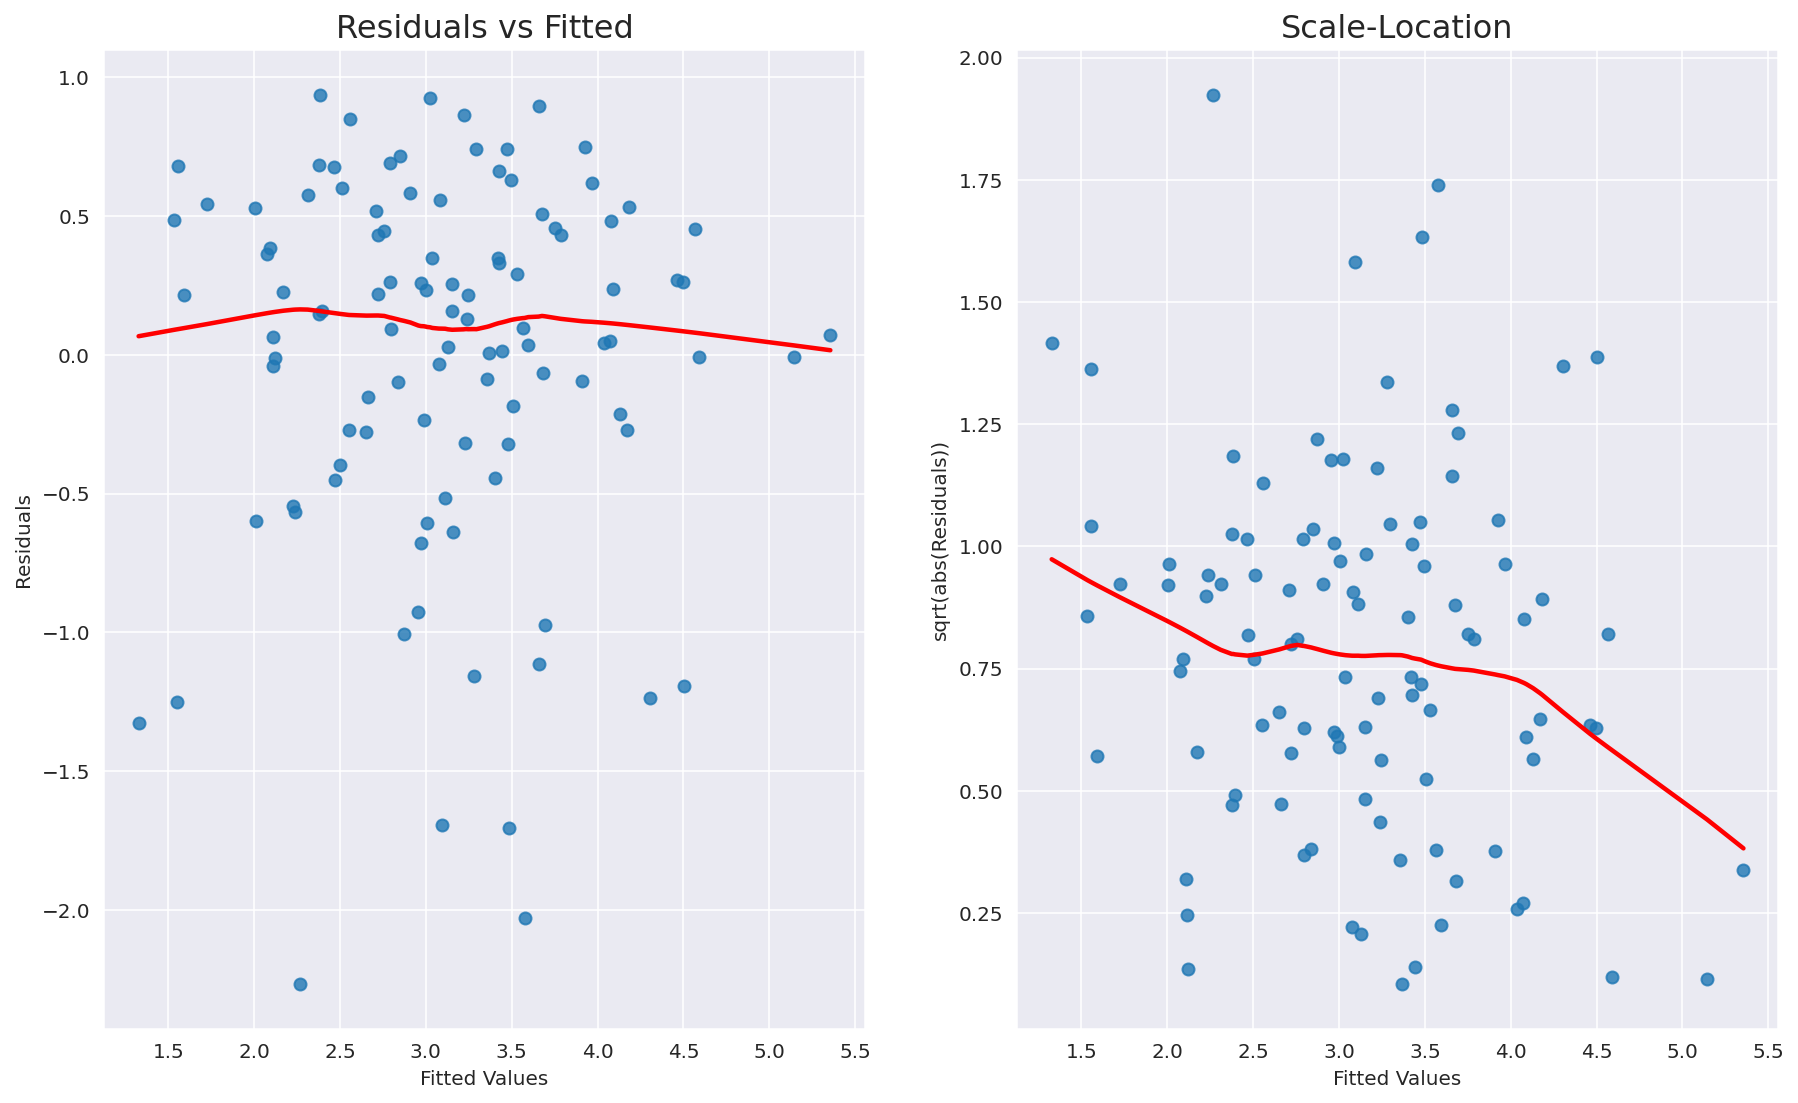

In [51]:
homoscedasticity_test(lin_reg_2)

Линии почти прямые, пограничный случай. Бройш-Паган тест показал гомоскедастичность, Гольдфельд-Квандт тест показал гетероскедастичность, также пограничный случай.

1.9522365734987386

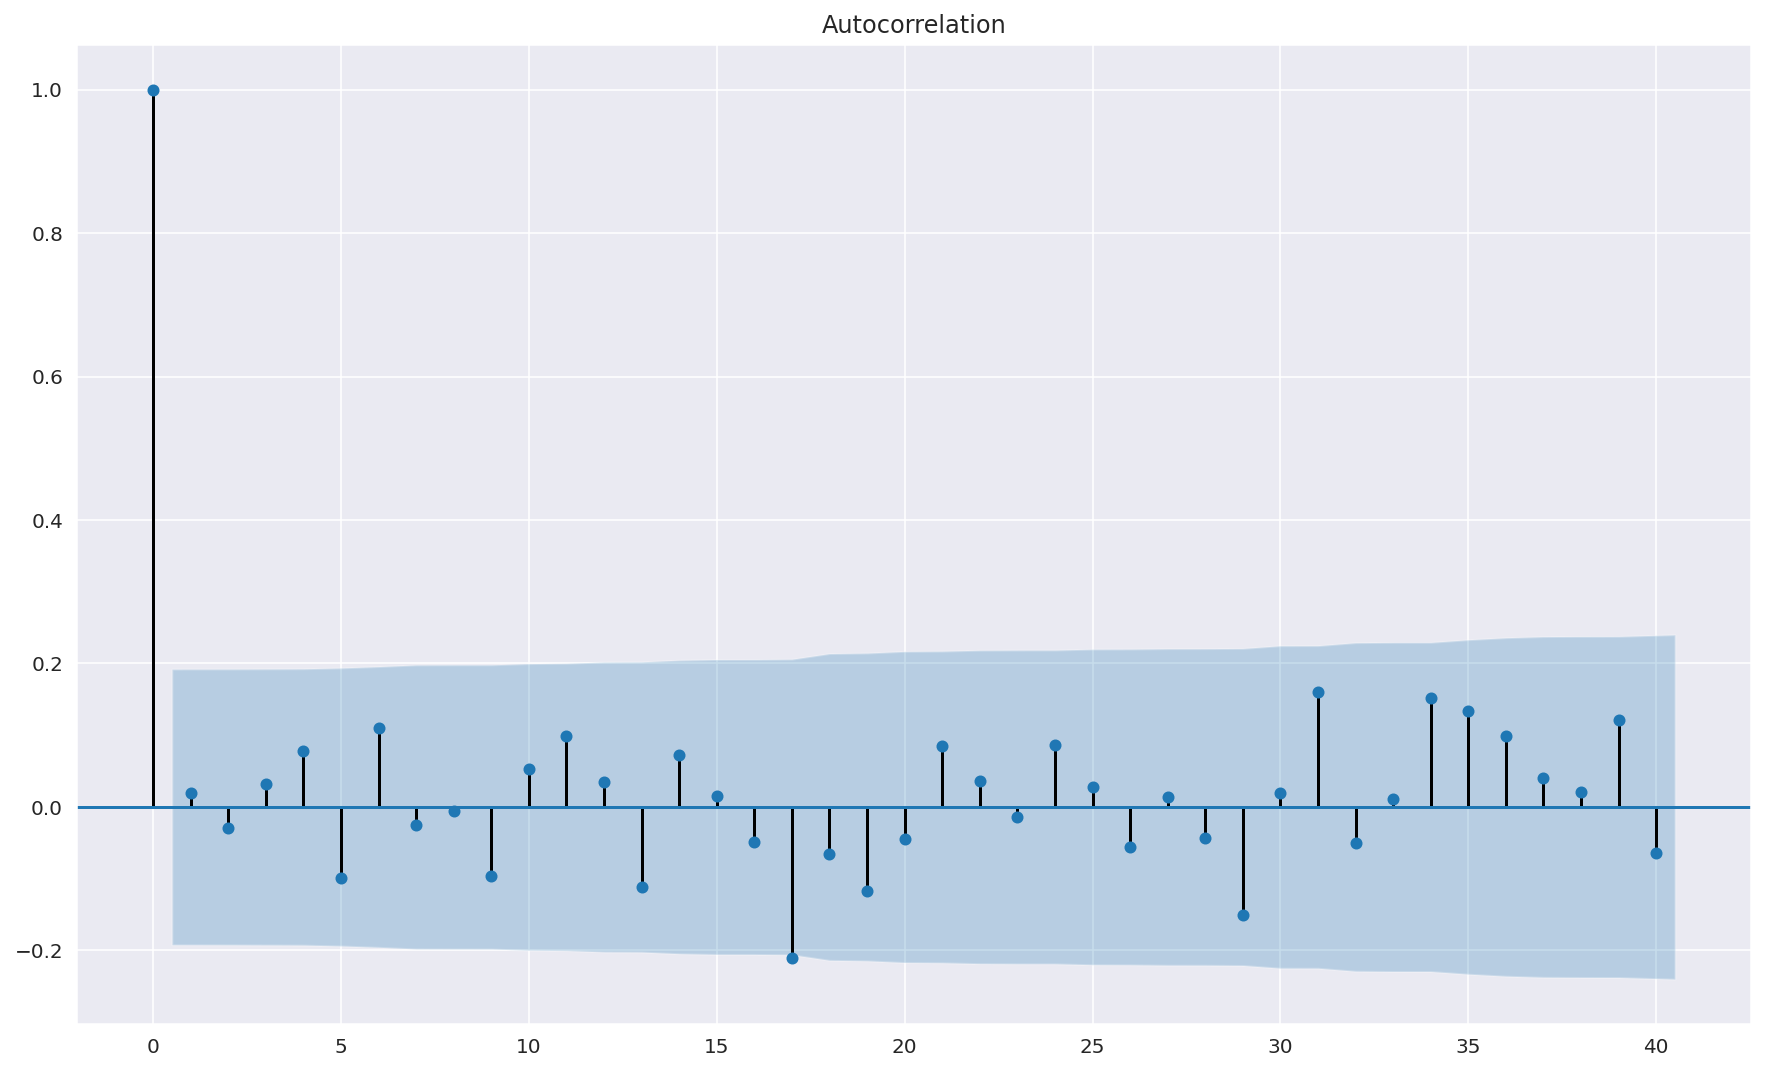

In [52]:
acf_2 = smt.graphics.plot_acf(lin_reg_2.resid, lags=40 , alpha=0.05)
acf_2.show()
statsmodels.stats.stattools.durbin_watson(lin_reg_2.resid, axis=0)

Значение стремится к 2, строго - положительная автокорреляция, нестрого можно сказать, что ее нет. По графику можно сказать, что автокорреляции на уровне значимости 0,05 нет.

Нормальность случайной ошибки для второй модели

Jarque-Bera test ---- statistic: 31.2555, p-value: 1.6328884100413887e-07
Shapiro-Wilk test ---- statistic: 0.9082, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.1790, p-value: 0.0022
Anderson-Darling test ---- statistic: 2.6828, 5% critical value: 0.7600


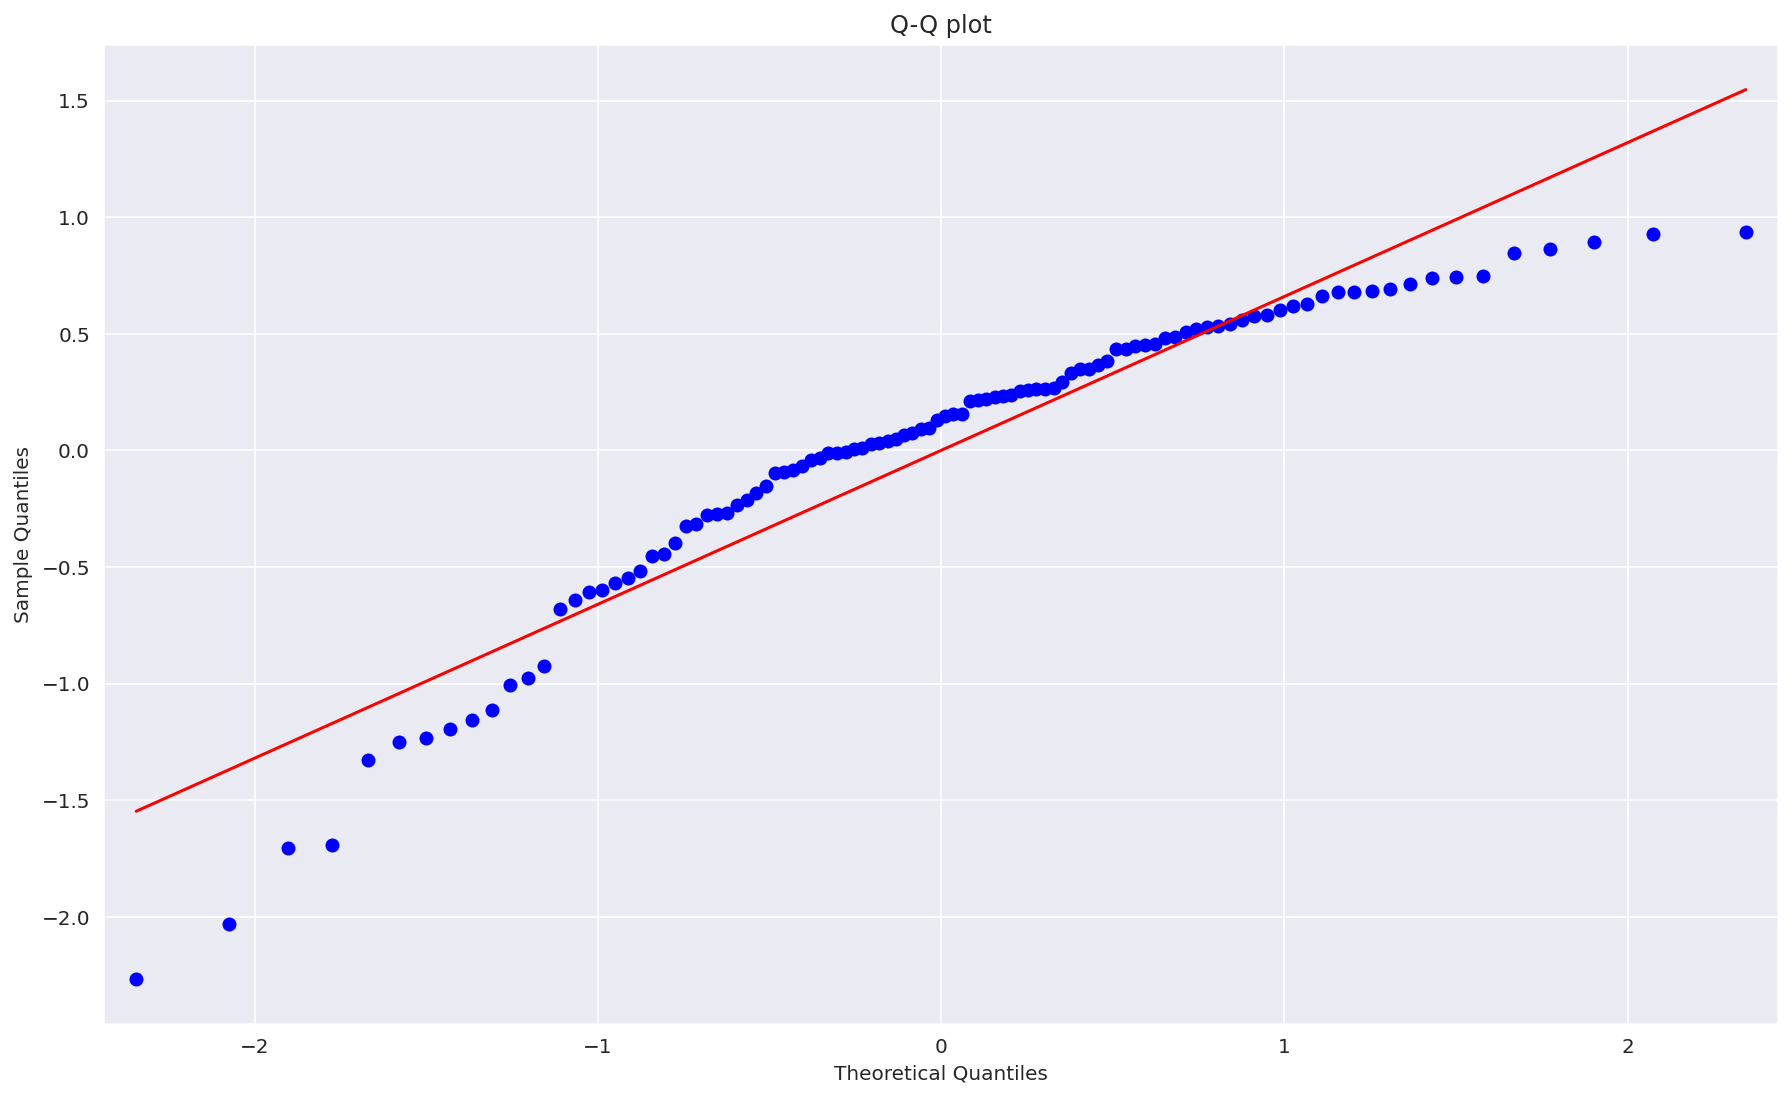

In [53]:
normality_of_residuals_test(lin_reg_2)

Гипотеза о нормальности распределния отвергается во всех тестах.

Тест Рамсея

In [54]:
statsmodels.stats.outliers_influence.reset_ramsey(lin_reg_2, degree=5)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[0.63777388]]), p=0.636892089644765, df_denom=90, df_num=4>

Третья модель

Предсказывает случии заражения в стране, не учитывая показатели пандемии

LinearRegression: r2 = 0.596

Coefs:
Intercept:                        -3.286
Average temperature per year      -0.028
Hospital beds per 1000 people     -0.531
Medical doctors per 1000 people    0.658
GDP/Capita                         0.326
Population                         0.908
Median age                         0.007
Population aged 65 and over (%)   -0.019
Population density per km2         0.239
Gini                               0.016
dtype: float64


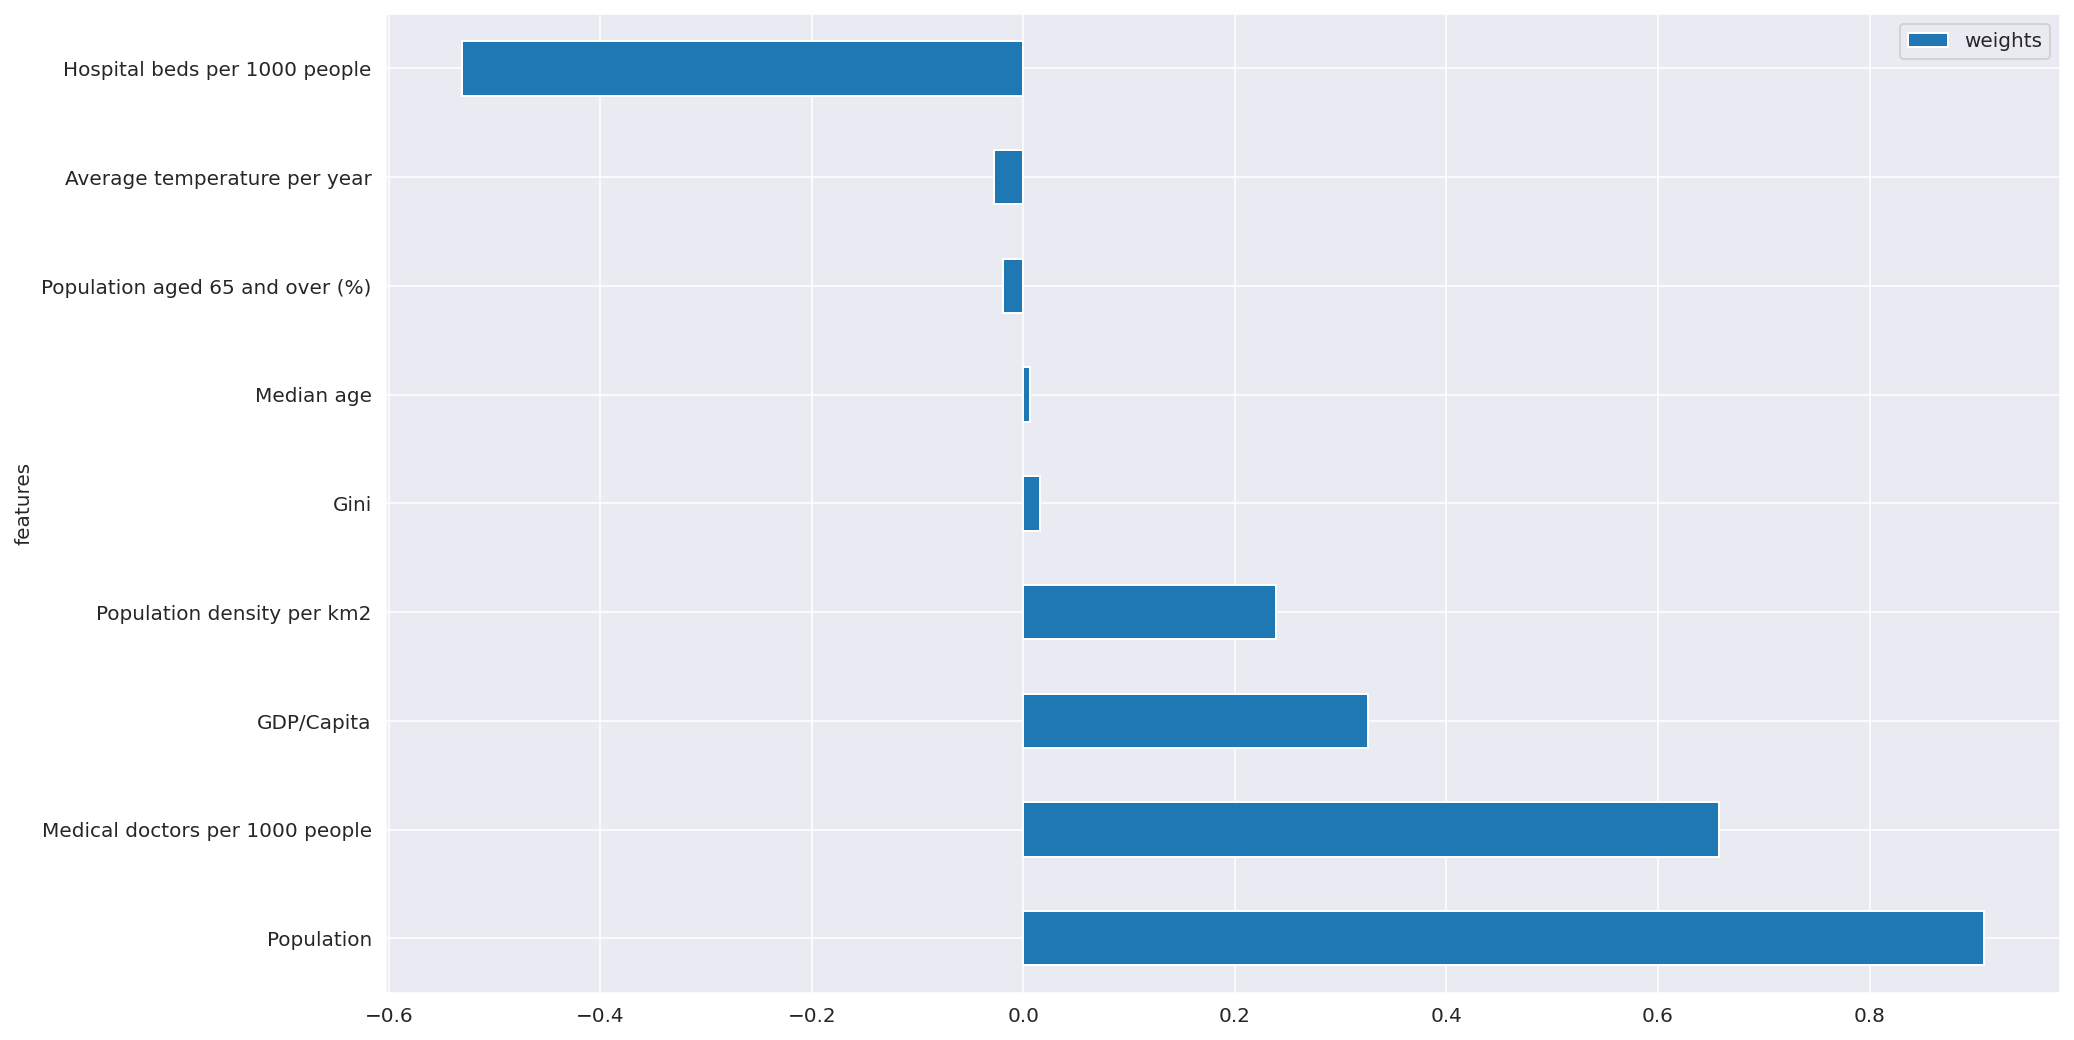

In [ ]:
# Target: Cases; Drops: Daily tests, Deaths

X_3 = fast_drop(data, ['Deaths', 'Cases', 'Daily tests'])
Y_3 = data['Cases']
linear_model_check(X_3, Y_3)

Проверка предпосылок теоремы Гаусса-Маркова и нормальности для второй модели модели

In [ ]:
X_constant_3 = sm.add_constant(X_3)
lin_reg_3 = sm.OLS(Y_3, X_constant_3).fit()
lin_reg_3.summary()

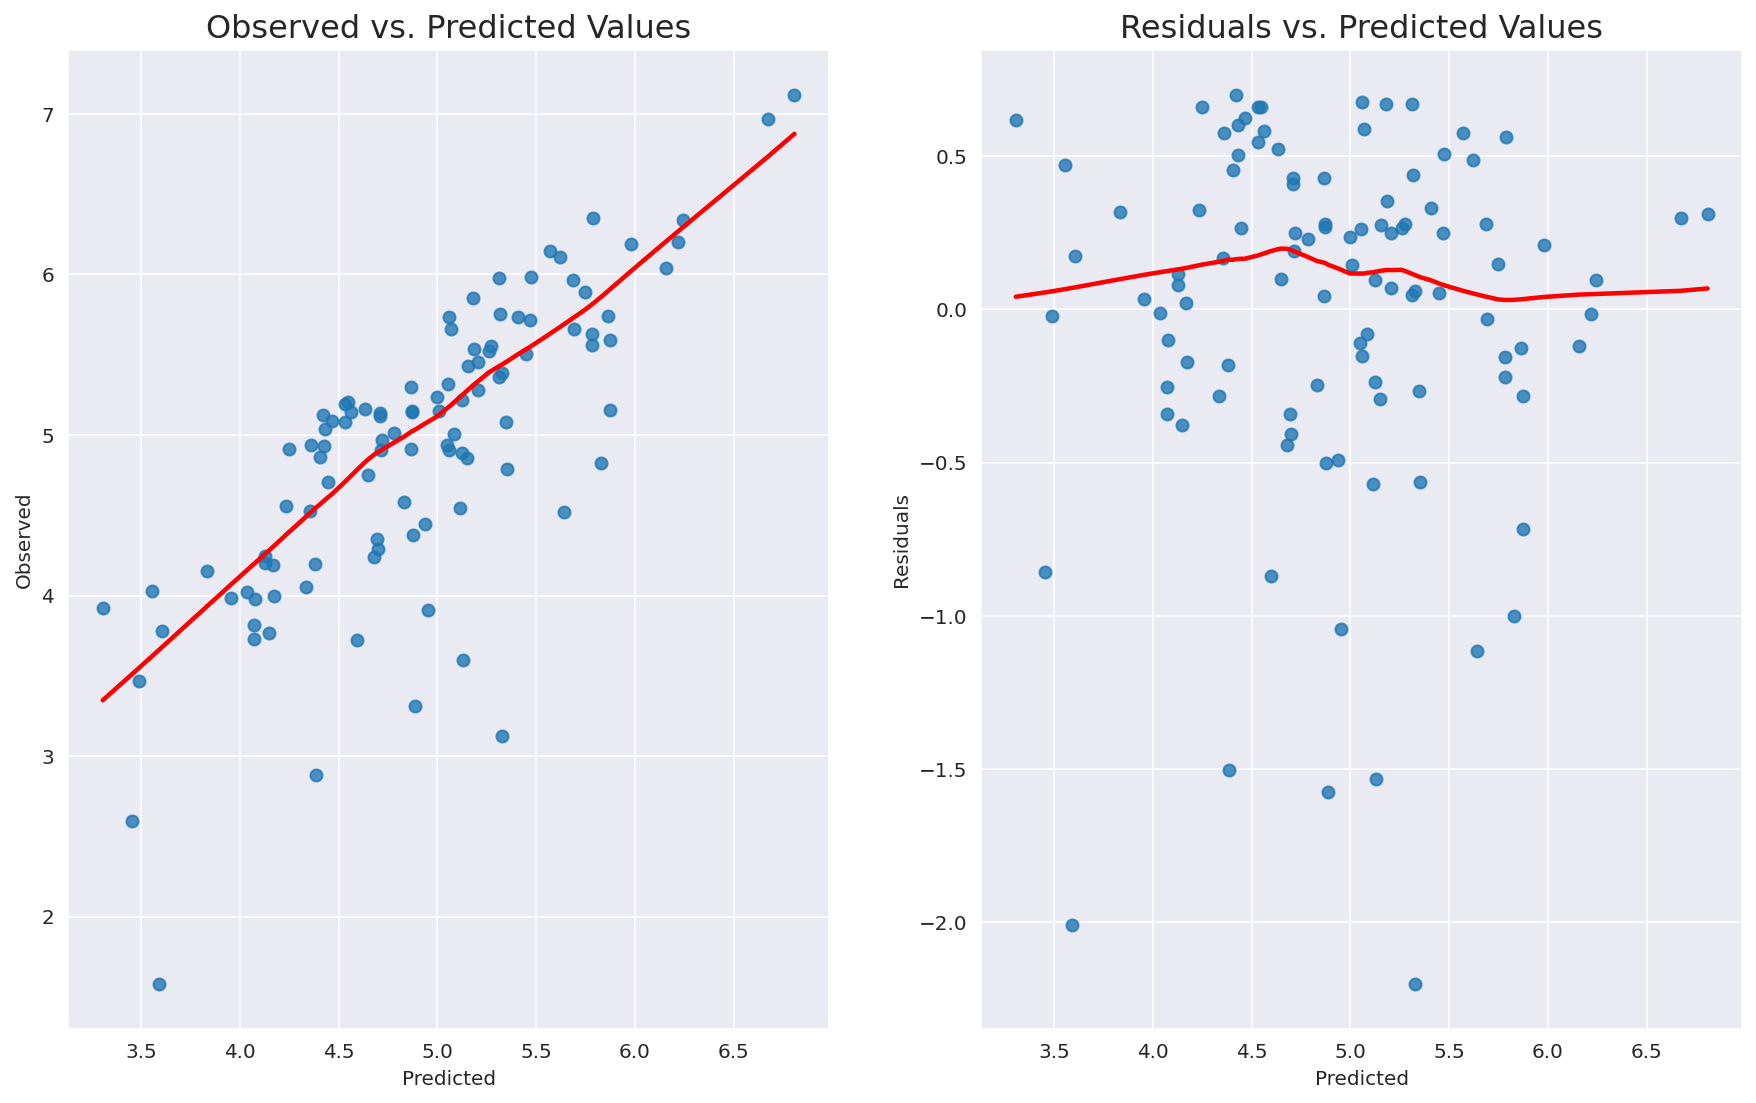

In [ ]:
linearity_test(lin_reg_3, Y_3)

Линии почти прямые, можно сказать, что линейность выполняется, пограничный случай.

In [ ]:
lin_reg_3.resid.mean()

8.343753038913677e-15

Значение около нуля, условие про ожидание остатков выполняется.

In [ ]:
vif_3 = [variance_inflation_factor(X_constant_3.values, i) for i in range(X_constant_3.shape[1])]
pd.DataFrame({'vif': vif_3[1:]}, index=X_3.columns).T

,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),Population density per km2,Gini
vif,2.987428,3.183114,3.994534,3.468435,1.158708,13.030038,7.880191,1.398857,1.548748


Мультиколлинеарность есть.


 Breusch-Pagan test ----
                                  value
Lagrange multiplier statistic  8.655738
p-value                        0.469640
f-value                        0.948189
f p-value                      0.487817

 Goldfeld-Quandt test ----
                value
F statistic  1.681817
p-value      0.047921

 Residuals plots ----


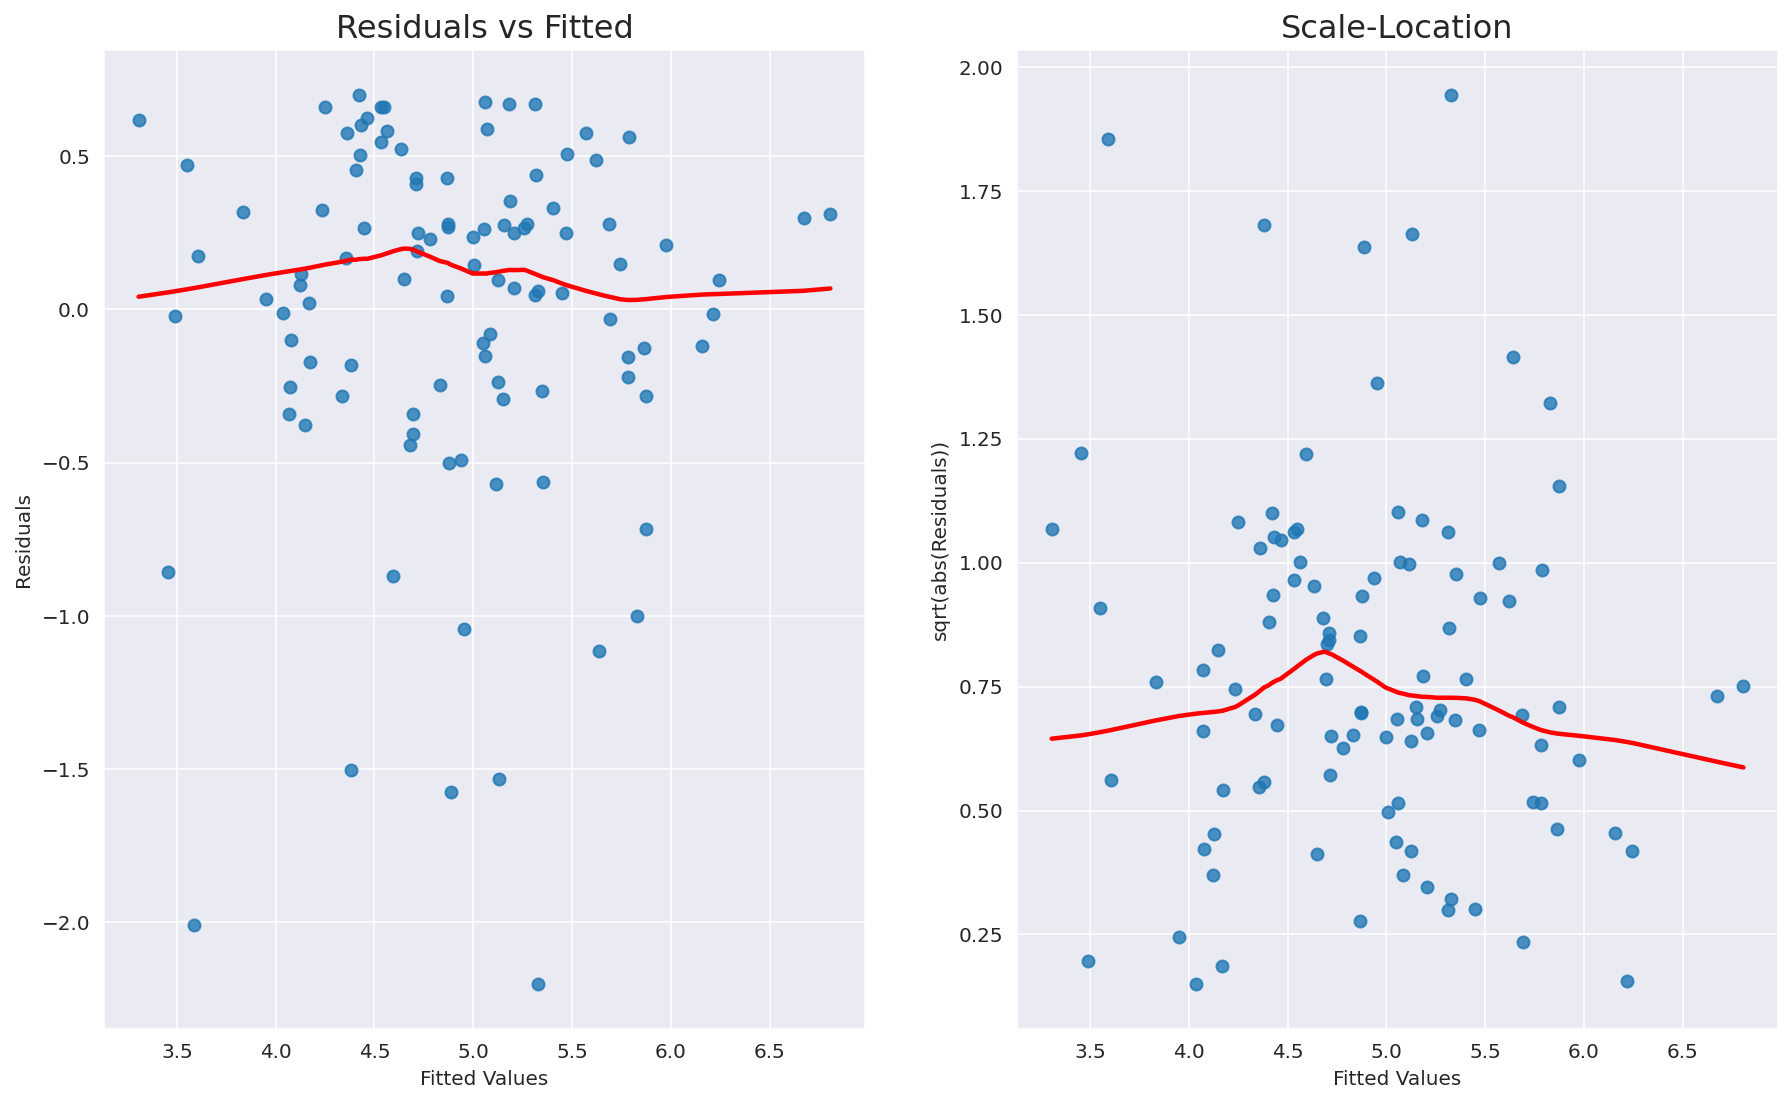

In [ ]:
homoscedasticity_test(lin_reg_3)

Линии почти прямые, пограничный случай. Бройш-Паган тест показал гомоскедастичность, Гольдфельд-Квандт тест показал гетероскедастичность, также пограничный случай.

1.8927224176922206

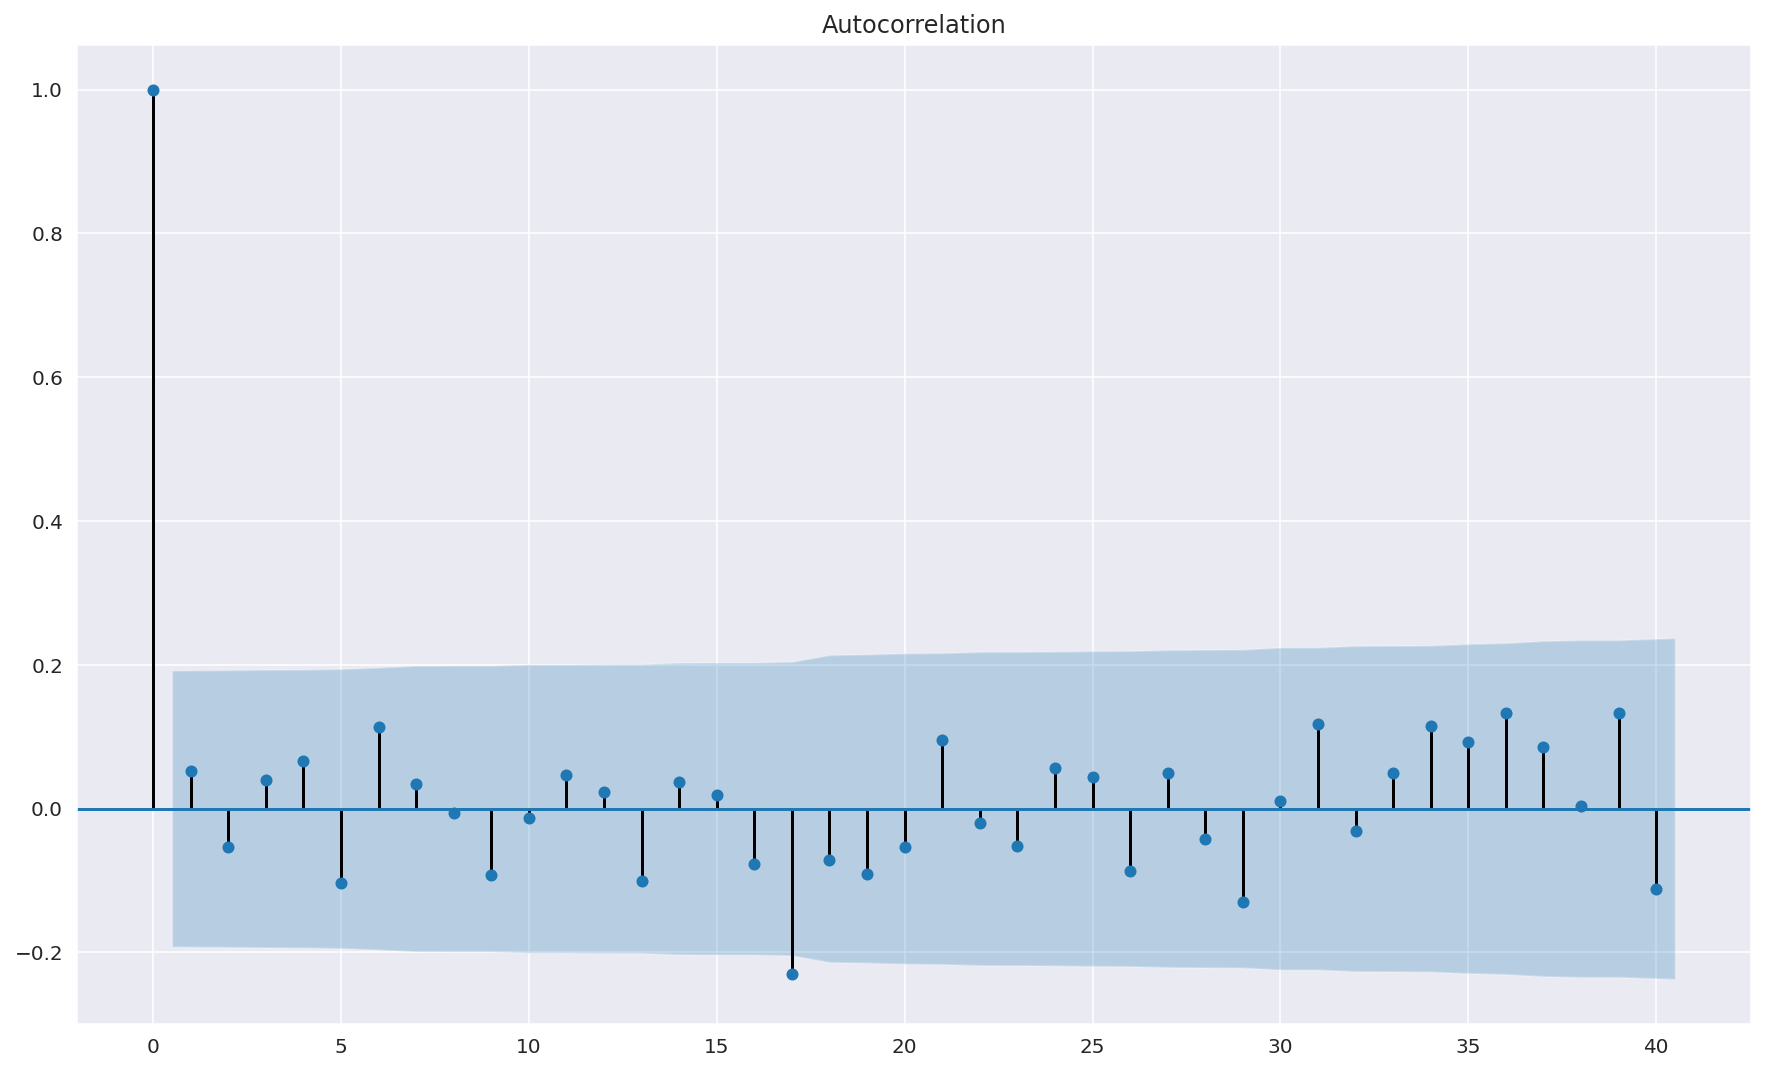

In [ ]:
acf_3 = smt.graphics.plot_acf(lin_reg_3.resid, lags=40 , alpha=0.05)
acf_3.show()
statsmodels.stats.stattools.durbin_watson(lin_reg_3.resid, axis=0)

Значение стремится к 2, строго - положительная автокорреляция, нестрого можно сказать, что ее нет. По графику можно сказать, что автокорреляции на уровне значимости 0,05 нет.

Нормальность случайной ошибки для третьей модели

Jarque-Bera test ---- statistic: 77.0860, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.8661, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.2416, p-value: 0.0000
Anderson-Darling test ---- statistic: 3.3904, 5% critical value: 0.7600


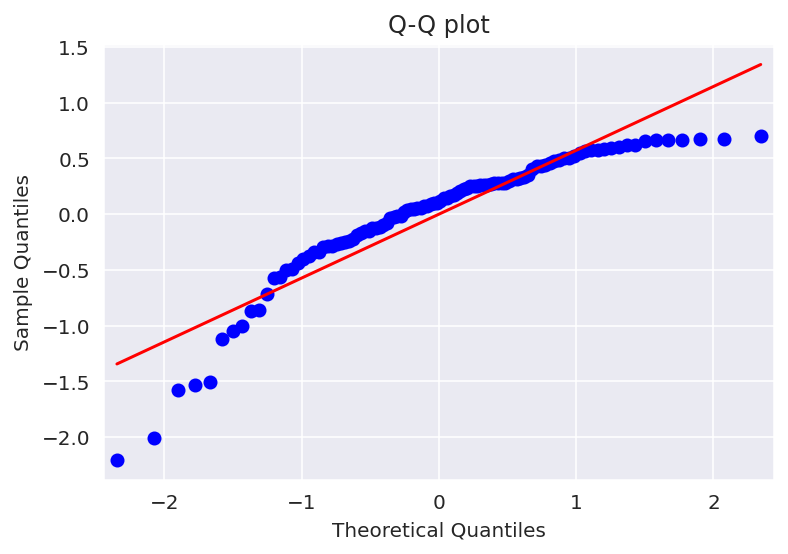

In [ ]:
normality_of_residuals_test(lin_reg_3)

Гипотеза о нормальности распределния отвергается во всех тестах.